# Fast Gradient Sign Method

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset
from modules.fgsm import *

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
# Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack


This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

\begin{equation}
\tag{1.1}
\widetilde{x} = x + \eta
\end{equation}

\begin{equation}
\tag{1.2}
\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))
\end{equation}

Since we scale the data to a range of [0, 1] first and then standardize, we have to standardize epsilon as well.

In [21]:
def compare_examples_fgsm(epsilon, idx, folder=None):
    '''
    Generates an example using FGSM and summarizes the attack.
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    folder  -- If given image will be saved to this folder
    '''

    ## Get data
    image_clean, target_class = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_class.unsqueeze_(0)

    ## Predict clean example
    labels, confidences, gradient = predict(model, image_clean, target_class, return_grad=True)
    label_clean = labels[0]
    conf_clean = confidences[0]
    
    ## Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, mean, std, epsilon, gradient)    
    labels, confidences, _ = predict(model, image_adv, target_class, return_grad=False)
    label_adv = labels[0]
    conf_adv = confidences[0]
    
    ## Plot
    summarize_attack(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_class, idx,
                        folder=folder)

In [36]:
def get_attack_series(epsilons, sample, save=False):
    '''
    Generates four adversaries with the specified epsilons and displays them along with the clean image.
    
    Inputs:
    epsilons -- List of four attack strengths
    sample   -- Number of the sample to use for attacks
    save     -- Saves image series to folder FGSM is True

    Returns:
    output   -- Generated image series
    '''
      
    assert(len(epsilons) == 4)
    
    image_clean, target_class = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    target_class.unsqueeze_(0)

    # Predict clean example
    predicted_classes, confidences, gradient = predict(model, image_clean, target_class, return_grad=True)
    
    # Compute adversarial image and predict for it.
    image_0 = show_tensor_image(image_clean)
    image_1 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[0], gradient))
    image_2 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[1], gradient))
    image_3 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[2], gradient))
    image_4 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[3], gradient))

    # Put images side-by-side
    images = [image_0, image_1, image_2, image_3, image_4]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)
    output = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    
    for im in images:
      output.paste(im, (x_offset,0))
      x_offset += im.size[0]

    if save is True:
        output.save("plots/FGSM/Sample_" + str(sample) + "_series.png")
    
    return output

## 0. Introduction

			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				14.81%



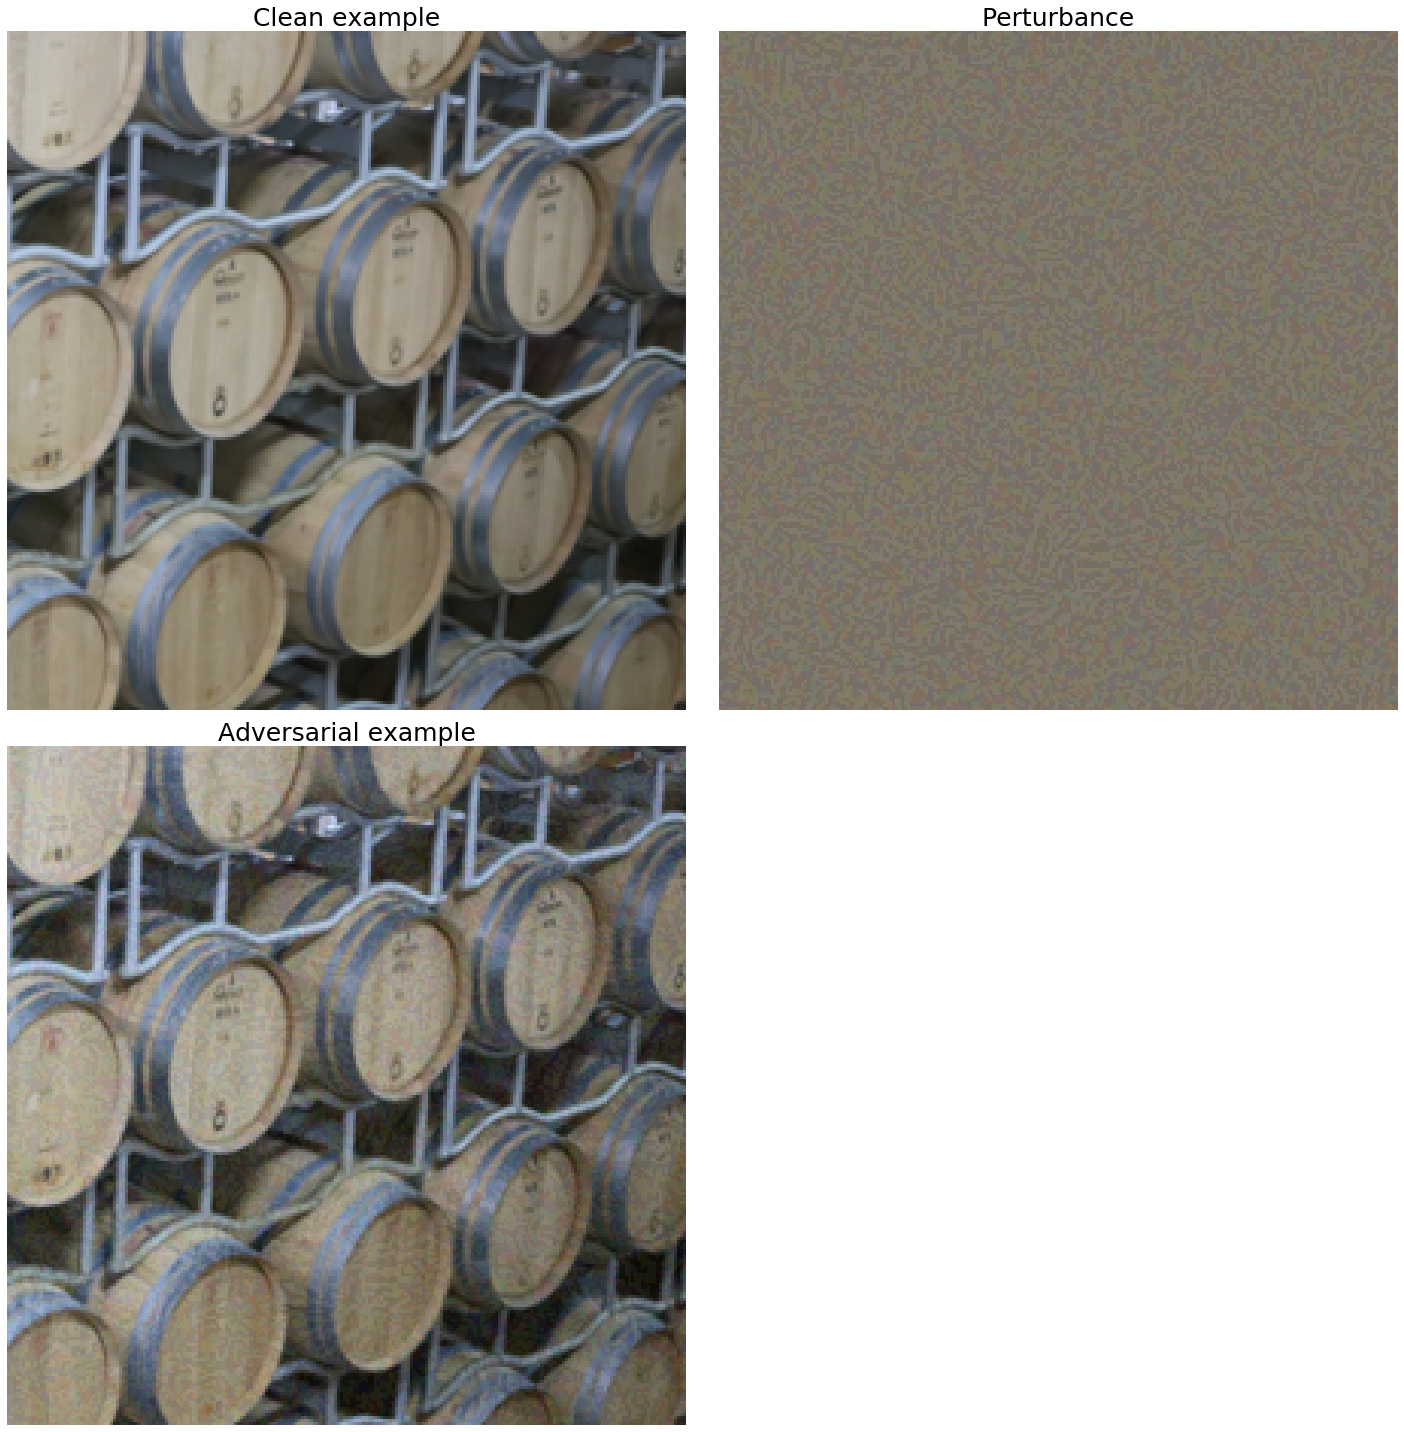

In [24]:
# Example with highest confidence
epsilon = 6/255
idx = 766

compare_examples_fgsm(epsilon, idx, folder="FGSM")

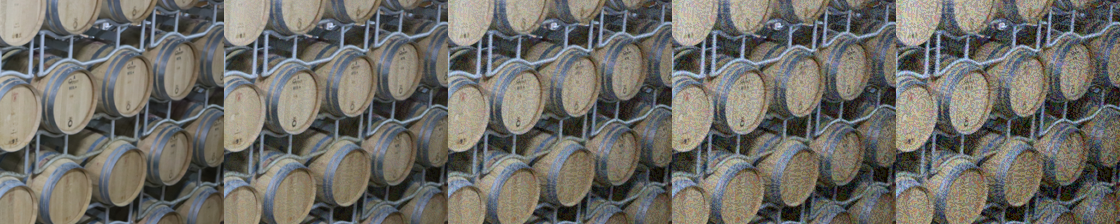

In [37]:
# Series of adversaries
samle = 766
epsilons = [4/255, 8/255, 12/255, 16/255]

images = get_attack_series(epsilons, sample)
images

## 1. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 1.1 Intervals of initial confidences

In [8]:
def confidence_interval(min_confidence, max_confidence):
    '''
    Splits predictions on clean dataset into provided interval of confidences. Then crafts adversarial examples
    from it for correct initital predictions and fixed epsilons and returns confidences, top1 and top5
    for those.
    
    Inputs:
    min_confidence -- Minimum confidence to consider
    max_confidence -- Maximum confidence to consider
    
    Returns:
    result         -- Dataframe with top1, top5 and confidence for prediction
    '''
    
    # Set perturbation
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255,
                4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]

    # Take list results
    result = pd.read_csv("results/Clean-Predictions.csv", index_col=0)

    # Filter correct predictions
    samples = result.loc[result["Accuracy Top 1"] == 1]

    # Filter confidence
    samples = samples.loc[samples["Confidence"] > min_confidence]
    samples = samples.loc[samples["Confidence"] <= max_confidence]

    # Get samples
    samples = list(samples["Sample"])

    # Predict
    accurcy_top1 = []
    accurcy_top5 = []
    confidence_adversarial = []

    for epsilon in epsilons: 
        acc_sub_adver_top1 = []
        acc_sub_adver_top5 = []
        conf_sub_adver = []    
        i = 1

        for sample in samples:
            image_as_tensor, label = data_loader.dataset[sample]
            image_as_tensor.unsqueeze_(0)
            label.unsqueeze_(0)

            clear_output(wait=True)       
            print("Running for epsilon {:.2f}".format(epsilon*255))
            print("Sample: "+ str(i))
            print("Accuracy adversarial: {:.2f}".format(np.mean(acc_sub_adver_top1)))
            print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))

            # Predict with clean image
            gradient, corr, _, _, _ = predict(model, image_as_tensor, label, return_grad=True)

            # Generate adversarial example only if initial prediction was correct
            if corr == 1:            
                # Predict with adversarial image
                perturbed_data = apply_fgsm(image_as_tensor, epsilon, gradient)
                _, top1, top5, conf, _ = predict(model, perturbed_data, label)
                acc_sub_adver_top1.append(top1)
                acc_sub_adver_top5.append(top5)
                conf_sub_adver.append(conf)

            else:
                acc_sub_adver_top1.append(0)
                acc_sub_adver_top5.append(0)
                conf_sub_adver.append(0)

            i += 1

        # Add accuracies and confidences for clean and adversarial example
        accurcy_top1.append(np.mean(acc_sub_adver_top1))
        accurcy_top5.append(np.mean(acc_sub_adver_top5))
        confidence_adversarial.append(np.mean(conf_sub_adver))

    # Save results
    result = pd.DataFrame()
    epsilon = np.array(epsilons) * 255
    result["Epsilon_255"] = epsilon
    result["Accuracy Top 1"] = accurcy_top1
    result["Accuracy Top 5"] = accurcy_top5
    result["Confidence"] = confidence_adversarial
    result.to_csv("results/FGSM-Conf" + str(int(min_confidence*100)) + ".csv") 
    
    return result

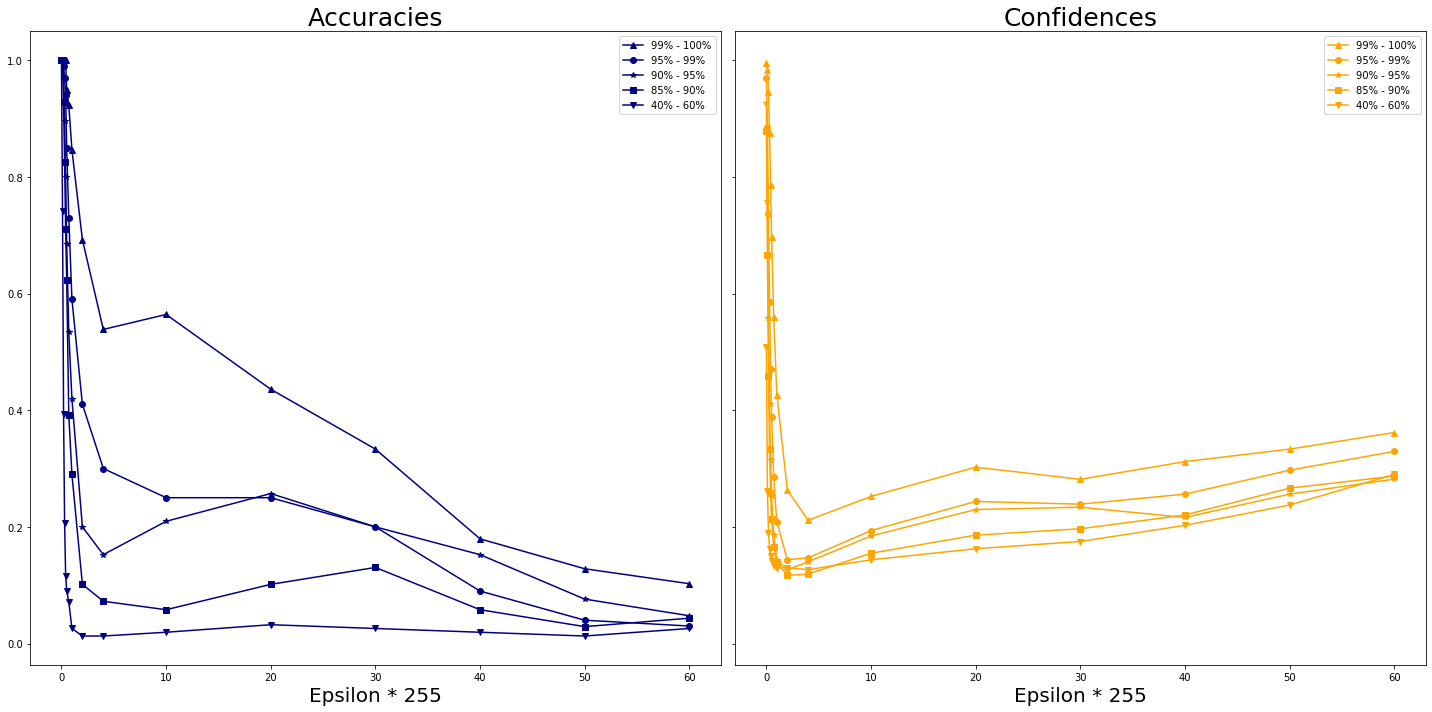

In [41]:
####### PLOT 3
# Load data
result_99 = pd.read_csv("results/FGSM-Conf99.csv")
result_95 = pd.read_csv("results/FGSM-Conf95.csv")
result_90 = pd.read_csv("results/FGSM-Conf90.csv")
result_85 = pd.read_csv("results/FGSM-Conf85.csv") 
result_40 = pd.read_csv("results/FGSM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
axs[0].set_title("Accuracies", fontsize=25)
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
axs[1].set_title("Confidences", fontsize=25)
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/FGSM/Accuracies_Confidences.pdf")
fig.savefig("plots/FGSM/Accuracies_Confidences.png")

### 1.2 Compare confidence levels

In [ ]:
def get_confidence_acc_class(epsilon, idx):
    '''
    ...
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    '''
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)
    image_clean = image_clean
    target_label = target_label

    ## Predict clean example
    gradient, acc, _, _, pred_class = predict(model, image_clean, target_label, return_grad=True)
              
    ## Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, epsilon, gradient)
    _, acc2, _, conf_adv, class_index = predict(model, image_adv, target_label, return_grad=False)
    label_adv = idx_to_name(class_index)
        
    return conf_adv, acc2, label_adv

Looking at all images we can see:
- The higher the initial confidence of the prediction, the harder it is on average to craft adversarial examples from it (Images from which adversarial examples can be crafted easily not neccessarily are easy to craft examples to! -> Ref.?)

- After a strong drop in confidence it increases steadily again on average for all images. Higher initial confidence means a higher overall level of confidence.

**Questions**
Find evidence for this in individual images
Look at confidence distributions


## 2. Indivdual Images

In [ ]:
def iterate_epsilons(idx):
    '''For a given sample number generates'''
    
    
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255, 3/255, 4/255, 5/255, 
                6/255, 8/255, 10/255, 12/255, 14/255, 16/255, 18/255, 20/255]

    conf_list = []
    acc_list = []

    print("Epsilon \t Accuracy \t Confidence \t Label")

    for epsilon in epsilons:
        conf_adv, acc, predicted_label = get_confidence_acc_class(epsilon, idx)
        conf_list.append(conf_adv)
        acc_list.append(acc)
        print(str(epsilon*255) + "\t\t\t" + str(acc) + "\t" + str(conf_adv) + "\t" + predicted_label)

    plt.plot(np.array(epsilons)*255, conf_list, color='orange', label='Confidence')
    plt.plot(np.array(epsilons)*255, acc_list, color='navy', label='Accuracy')
    plt.xlabel("Epsilon *255", fontsize=15)
    plt.legend()
    plt.savefig("plots/FGSM/Confidence_Levels-Sample" + str(idx)+ ".pdf")
    plt.savefig("plots/FGSM/png/Confidence_Levels-Sample" + str(idx)+ ".png")
    plt.show()

In [ ]:
epsilons = [1/255, 2/255, 4/255, 6/255, 8/255, 10/255]


result = pd.DataFrame()

for epsilon in epsilons:   
    conf = []
    
    for idx in range(1000):
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print(idx+1)
        conf_adv, acc, label_adv = get_confidence_acc_class(epsilon, idx)
        
        if acc == 1:
            conf.append(conf_adv)

        else:
            conf.append(0)

    result["Epsilon " + str(int(epsilon*255))] = conf

#result.to_csv("results/googleNet_ImageNet_FGSM-2.csv")

### 2.1 Inspecting data



#### 2.1.1 Highest adverarial confidences

We now look at the highest possible confidences for adversarial examples in the dataset.

In [9]:
## Find largest confidences
result = pd.read_csv("results/googleNet_ImageNet_FGSM-accuracies-corr_only.csv", index_col=0)
result.sort_values(by="Epsilon 2", axis=0, ascending=False).head(15)

,Epsilon 1,Epsilon 2,Epsilon 4,Epsilon 6,Epsilon 8,Epsilon 10
258,0.795896,0.764548,0.584982,0.535900,0.493167,0.512234
615,0.623381,0.760889,0.687373,0.652920,0.540026,0.454741
127,0.843634,0.747094,0.671801,0.662372,0.663531,0.703478
880,0.845605,0.744072,0.676975,0.753801,0.815303,0.828566
596,0.673993,0.729044,0.740170,0.714127,0.691583,0.653798
574,0.411680,0.708652,0.856329,0.759716,0.598320,0.480245
590,0.908927,0.698470,0.405508,0.350295,0.336255,0.306850
336,0.726056,0.695661,0.238356,0.078428,0.121614,0.191409
236,0.874574,0.693394,0.587018,0.569412,0.556657,0.539673
401,0.727821,0.687669,0.571852,0.593862,0.580629,0.587307


			Clean image	 Adversarial image

Actual class: 		umbrella			umbrella
Predicted class: 	umbrella			lionfish
Confidence: 		49.23%				76.45%



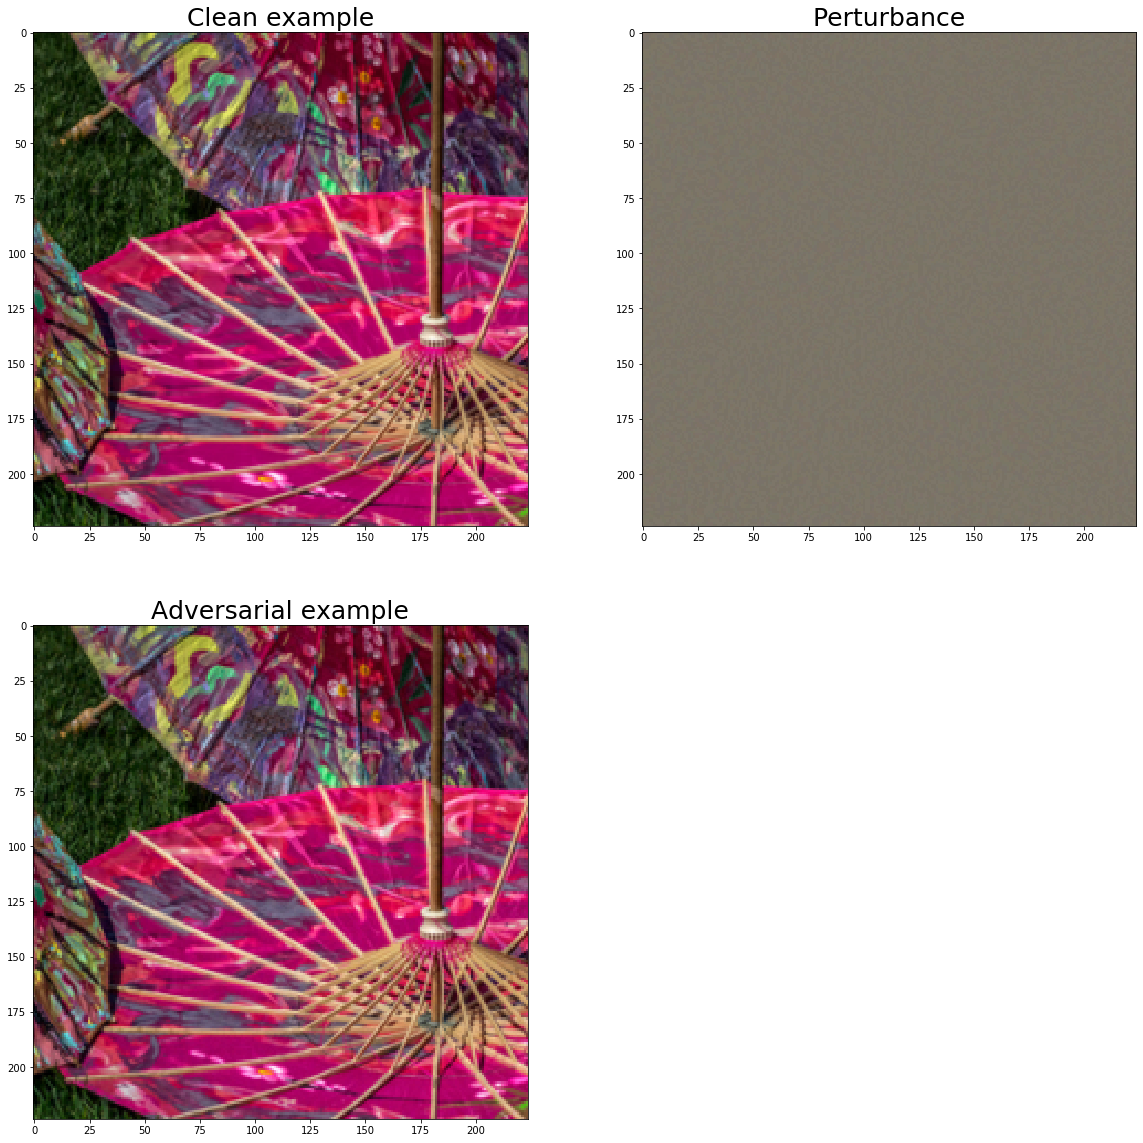

In [10]:
epsilon = 2/255
idx = 258

compare_examples_fgsm(epsilon, idx)

			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				14.81%



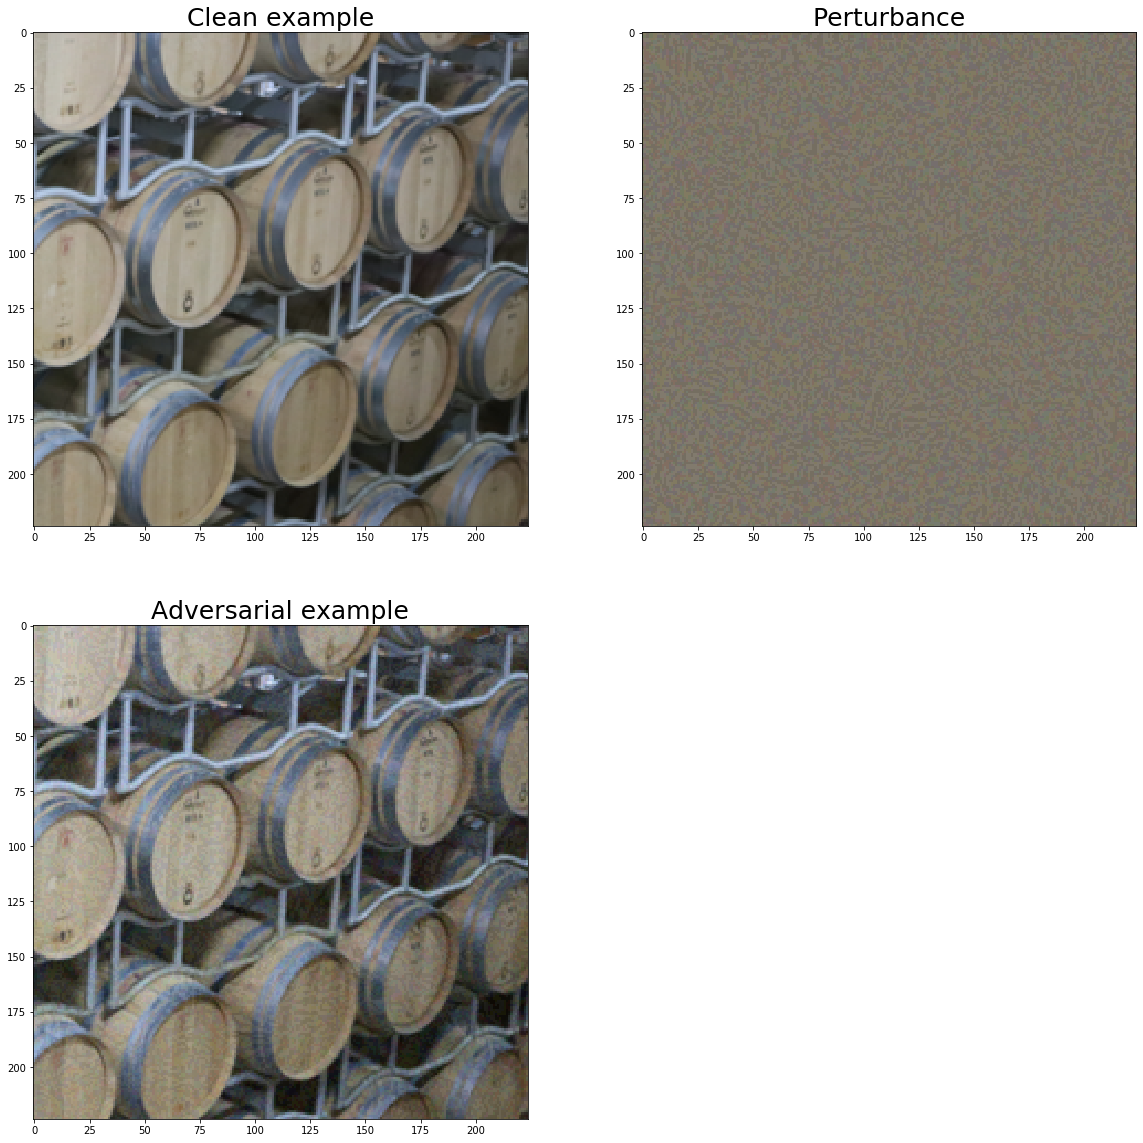

In [11]:
## Example with highest confidence
epsilon = 6/255
idx = 766 #766

compare_examples_fgsm(epsilon, idx)

### 2.2 Computing attacks

We now use individual images for attacks.

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


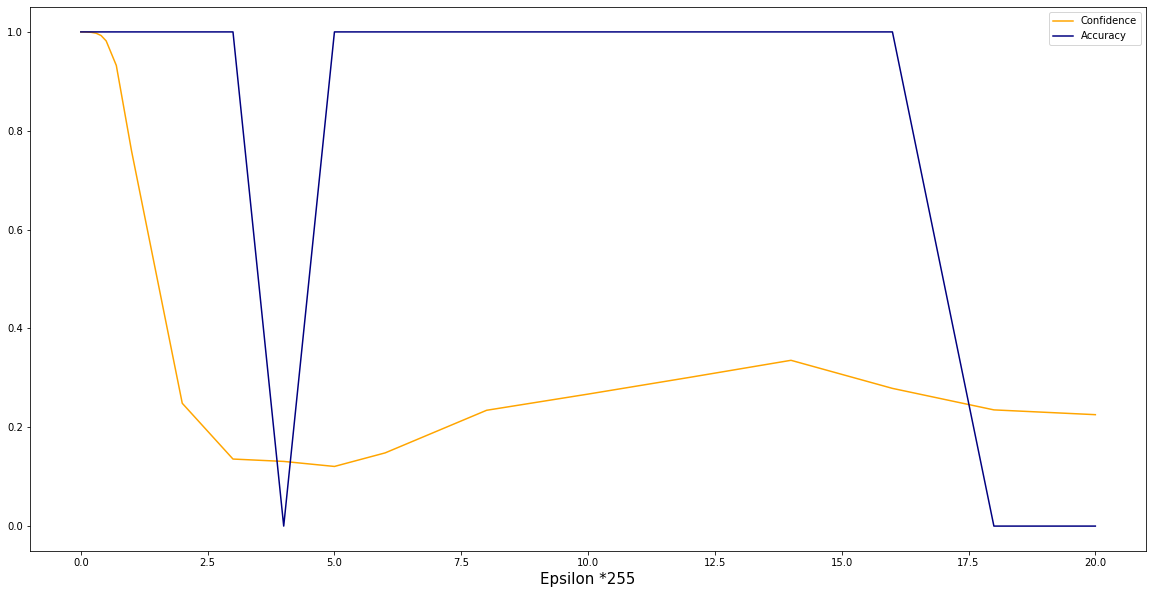

In [15]:
iterate_epsilons(766)

In [19]:
## Butchered version to get confidence dist for all samples. Get top 5 using new function!!!!!

def predict(model, image, target_label, return_grad=False, return_dist=False):
    '''
    Predicts the class of the given image and compares the prediction with the provided label.
    
    Inputs:
    model           -- net
    image           -- Input image as tensor of shape (1, 3, 224, 224)
    target_label    -- Target label as tensor of shape (1)
    return_grad     -- Returns gradient if set True
    
    Returns:
    gradient        -- None if return_grad=False. Otherwise the gradient from the prediction
                       as a tensor of shape ().
    top_1           -- Integer of value 1 if class is correct, otherwise 0.
    top_5           -- Integer of value 1 if target class is among the 5 most confident predicted classes.
    confidence      -- Confidence of prediction.
    predicted_label -- Predicted label as integer.
    '''      
        
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, target_label)
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
   

    ## Get class index and confidence for prediction 
    prediction = torch.nn.functional.softmax(prediction[0].cpu().detach(), dim=0).numpy()
    
    
    ## Get class label indices corresponding to the five highest confidences
    predicted_class_index = prediction.argsort()[-5:][::-1]

        
    ## Get largest confidences
    confidence = prediction[predicted_class_index[0]]
    
    
    ## Calculate if prediction is correct        
    if predicted_class_index[0] == target_label:
        top_1 = 1
        
    else:
        top_1 = 0
     
    
    ## Calculate top 5 accuracy
    if target_label.numpy() in predicted_class_index:
        top_5 = 1
    else:
        top_5 = 0
    
    if return_dist == True:
        return gradient, top_1, top_5, confidence, predicted_class_index[0], prediction
    
    else:
        return gradient, top_1, top_5, confidence, predicted_class_index[0]

In [32]:
### Get confidence distribution of clean image
idx = 217

image_clean, target_label = data_loader.dataset[idx]
image_clean.unsqueeze_(0)
target_label.unsqueeze_(0)
image_clean = image_clean
target_label = target_label

## Predict clean example
gradient, _, _, conf_clean, label_clean, dist = predict(model, image_clean, target_label, return_grad=True, return_dist=True)

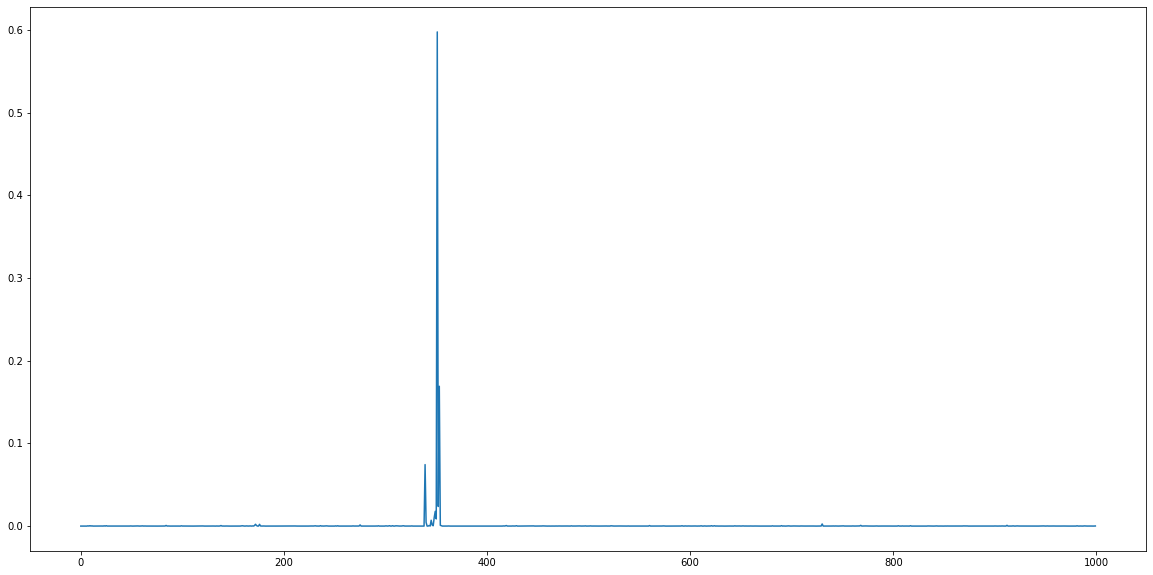

In [35]:
plt.plot(dist)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			1	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			1	0.23515305	bottlecap
20.0			1	0.22546048	bottlecap


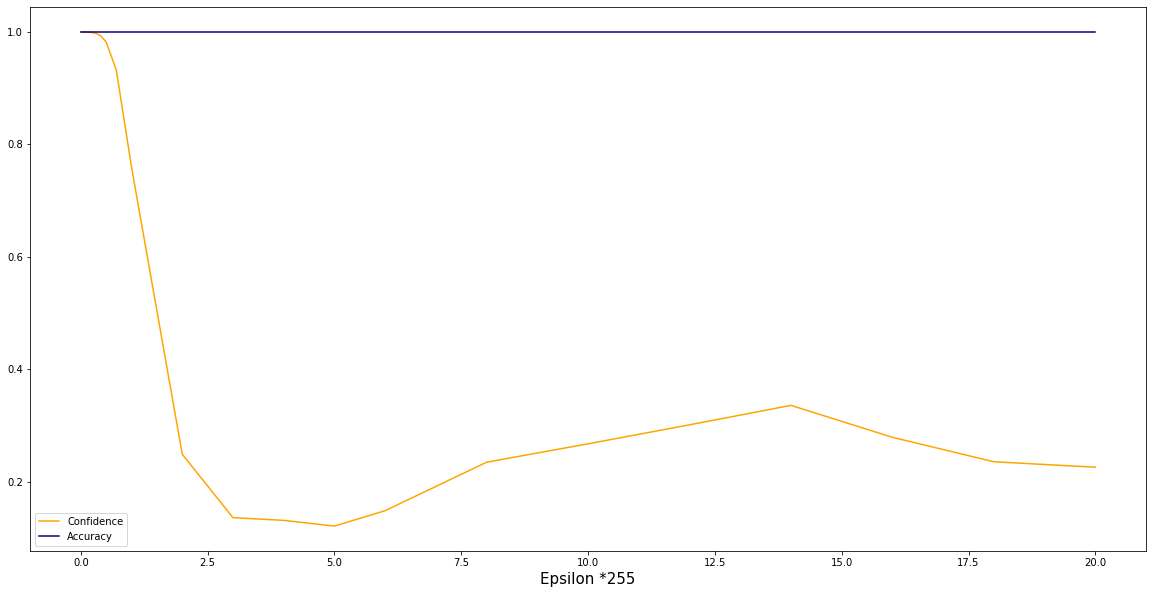

In [15]:
iterate_epsilons(766)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9996531	dial telephone, dial phone
0.1			1	0.9988556	dial telephone, dial phone
0.2			1	0.9970054	dial telephone, dial phone
0.3			1	0.9936348	dial telephone, dial phone
0.4			1	0.9883482	dial telephone, dial phone
0.5			1	0.98092127	dial telephone, dial phone
0.7			1	0.9590692	dial telephone, dial phone
1.0			1	0.90892726	dial telephone, dial phone
2.0			1	0.6984705	dial telephone, dial phone
3.0			1	0.52432066	dial telephone, dial phone
4.0			1	0.40550837	dial telephone, dial phone
5.0			1	0.3536904	dial telephone, dial phone
6.0			1	0.35029522	dial telephone, dial phone
8.0			1	0.33625463	dial telephone, dial phone
10.0			1	0.3068497	dial telephone, dial phone
12.0			0	0.2907374	spindle
14.0			0	0.32834187	spindle
16.0			0	0.27790448	spindle
18.0			0	0.2030631	spindle
20.0			0	0.17008948	spindle


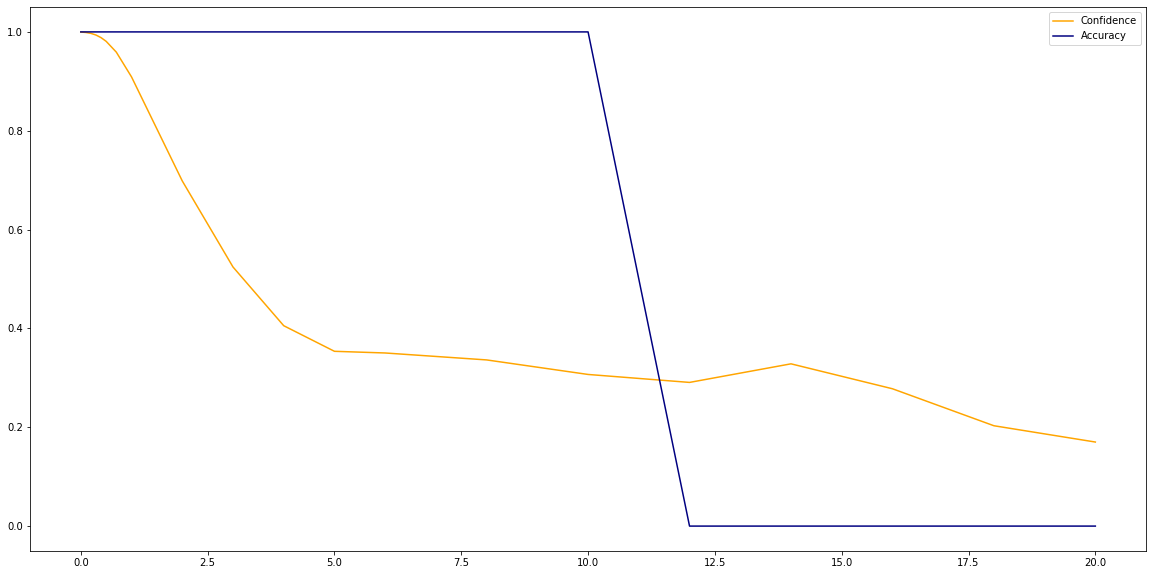

In [53]:
iterate_epsilons(590)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.99721515	honeycomb
0.2			1	0.9936559	honeycomb
0.3			1	0.98548675	honeycomb
0.4			1	0.9702776	honeycomb
0.5			1	0.94641435	honeycomb
0.7			1	0.87577116	honeycomb
1.0			1	0.7662984	honeycomb
2.0			1	0.6421063	honeycomb
3.0			1	0.6387259	honeycomb
4.0			1	0.63160247	honeycomb
5.0			1	0.64614445	honeycomb
6.0			1	0.68201077	honeycomb
8.0			1	0.80579555	honeycomb
10.0			1	0.9198083	honeycomb
12.0			1	0.9653693	honeycomb
14.0			1	0.9822119	honeycomb
16.0			1	0.9883703	honeycomb
18.0			1	0.99088913	honeycomb
20.0			1	0.9928846	honeycomb


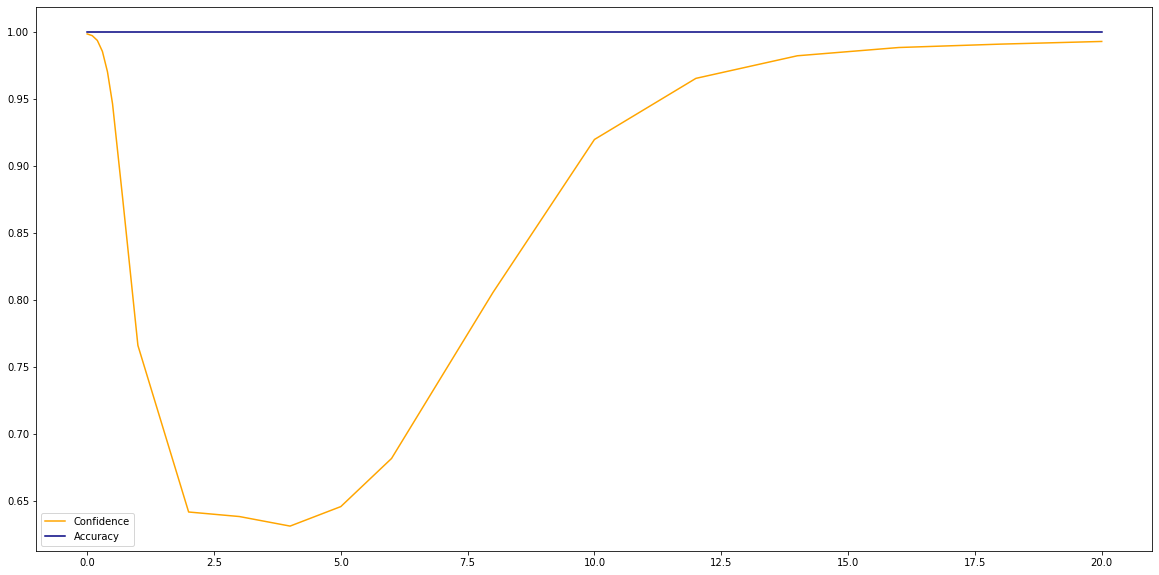

In [13]:
iterate_epsilons(132)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9978678	baseball
0.1			1	0.99073595	baseball
0.2			1	0.9740122	baseball
0.3			1	0.9442655	baseball
0.4			1	0.8999622	baseball
0.5			1	0.8442669	baseball
0.7			1	0.726144	baseball
1.0			1	0.58897096	baseball
2.0			1	0.35198572	baseball
3.0			1	0.24360058	baseball
4.0			1	0.18754263	baseball
5.0			1	0.15972885	baseball
6.0			1	0.14501931	baseball
8.0			1	0.11653368	baseball
10.0			1	0.13254663	baseball
12.0			1	0.16315761	baseball
14.0			1	0.19640179	baseball
16.0			1	0.2417866	baseball
18.0			1	0.2595709	baseball
22.0			1	0.2806484	baseball
26.0			1	0.24594808	baseball
32.0			1	0.18234633	baseball
40.0			0	0.21733066	poncho


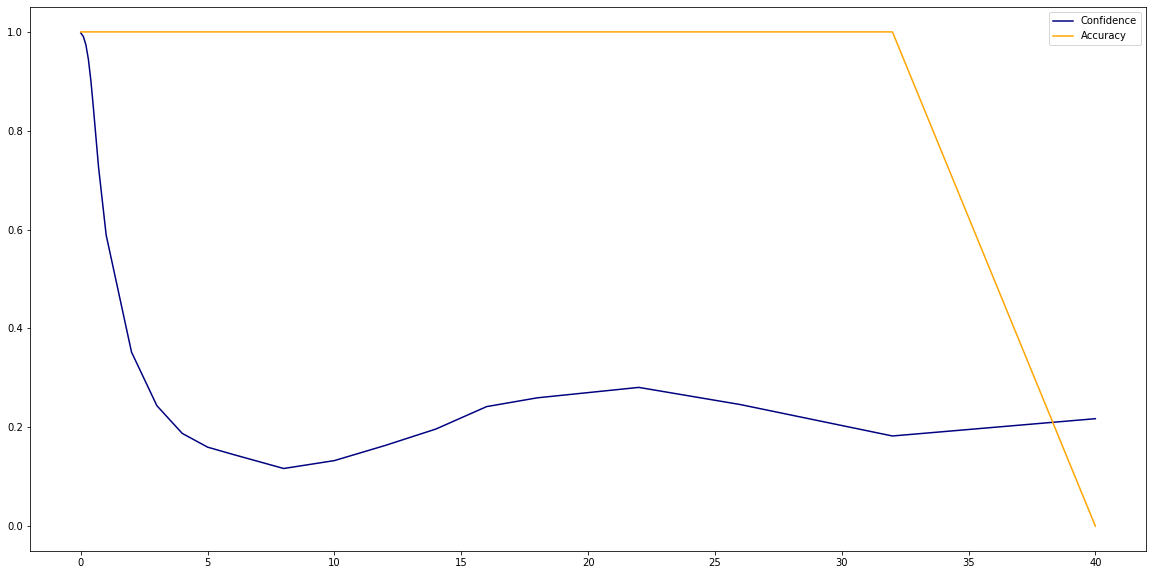

In [76]:
iterate_epsilons(241)

## Confidence 90%

In [92]:
result_aggregated.loc[result_aggregated["Confidence Mean"] <= 0.9]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
71,874,0.899523,0.065055,2,"trolleybus, trolley coach, trackless trolley"
72,411,0.898127,0.000000,1,apron
73,299,0.896682,0.000000,1,"meerkat, mierkat"
74,143,0.891660,0.000000,1,"oystercatcher, oyster catcher"
75,99,0.881549,0.058618,3,goose
...,...,...,...,...,...
447,907,0.058586,0.000000,1,wine bottle
448,241,0.055452,0.000000,1,EntleBucher
449,431,0.049087,0.000000,1,bassinet
450,212,0.043343,0.000000,1,English setter


In [93]:
get_image_by_class_index(874)
get_image_by_class_index(411)
get_image_by_class_index(299)
get_image_by_class_index(143)
get_image_by_class_index(99)

439
432
28
323
29


Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.83446777	trolleybus, trolley coach, trackless trolley
0.1			1	0.6487372	trolleybus, trolley coach, trackless trolley
0.2			1	0.45319882	trolleybus, trolley coach, trackless trolley
0.3			1	0.29786143	trolleybus, trolley coach, trackless trolley
0.4			1	0.19915761	trolleybus, trolley coach, trackless trolley
0.5			1	0.13972698	trolleybus, trolley coach, trackless trolley
0.7			1	0.077188194	trolleybus, trolley coach, trackless trolley
1.0			0	0.04112833	fire engine, fire truck
2.0			0	0.043476652	fire engine, fire truck
3.0			0	0.050705362	fire engine, fire truck
4.0			0	0.049495738	fire engine, fire truck
5.0			0	0.045976255	fire engine, fire truck
6.0			0	0.04359874	fire engine, fire truck
8.0			0	0.038465064	fire engine, fire truck
10.0			0	0.029530458	fire engine, fire truck
12.0			0	0.036188986	tow truck, tow car, wrecker
14.0			0	0.04578182	tow truck, tow car, wrecker
16.0			0	0.05101343	tow truck, tow car, wrecker
18.0			0	0.0529417

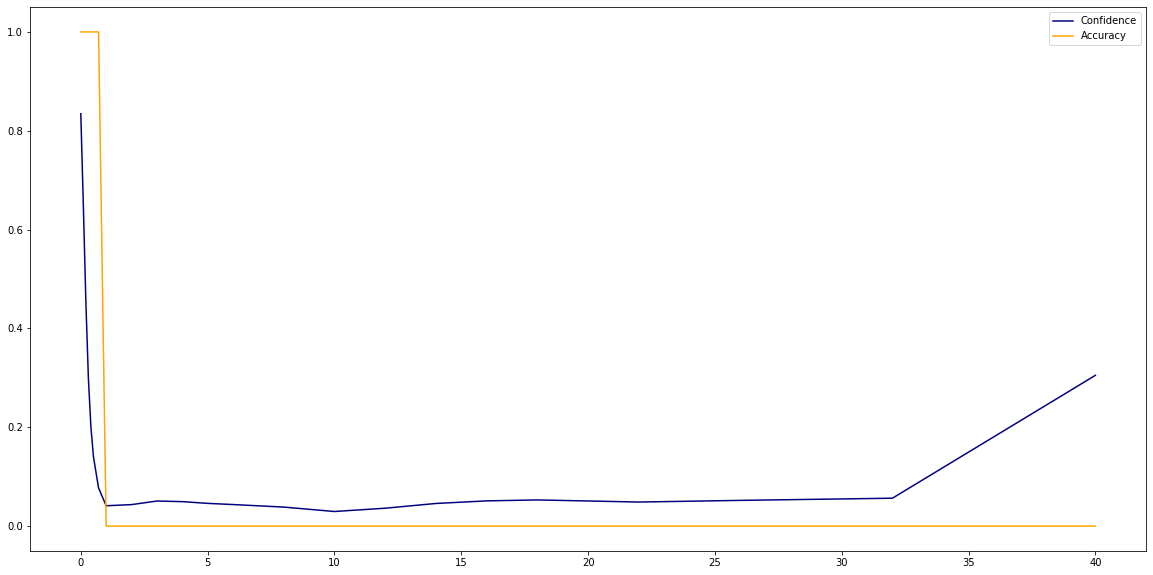

In [94]:
iterate_epsilons(439)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.89812696	apron
0.1			1	0.655235	apron
0.2			1	0.40885675	apron
0.3			1	0.26146814	apron
0.4			1	0.18003756	apron
0.5			0	0.16804919	lab coat, laboratory coat
0.7			0	0.19214581	lab coat, laboratory coat
1.0			0	0.20965621	lab coat, laboratory coat
2.0			0	0.2010445	lab coat, laboratory coat
3.0			0	0.19409224	lab coat, laboratory coat
4.0			0	0.19547743	lab coat, laboratory coat
5.0			0	0.19839363	lab coat, laboratory coat
6.0			0	0.20357373	lab coat, laboratory coat
8.0			0	0.19334966	lab coat, laboratory coat
10.0			0	0.1673113	lab coat, laboratory coat
12.0			1	0.22230485	apron
14.0			1	0.31577015	apron
16.0			1	0.41265127	apron
18.0			1	0.5240265	apron
22.0			1	0.680703	apron
26.0			1	0.7688002	apron
32.0			1	0.83184946	apron
40.0			1	0.8058245	apron


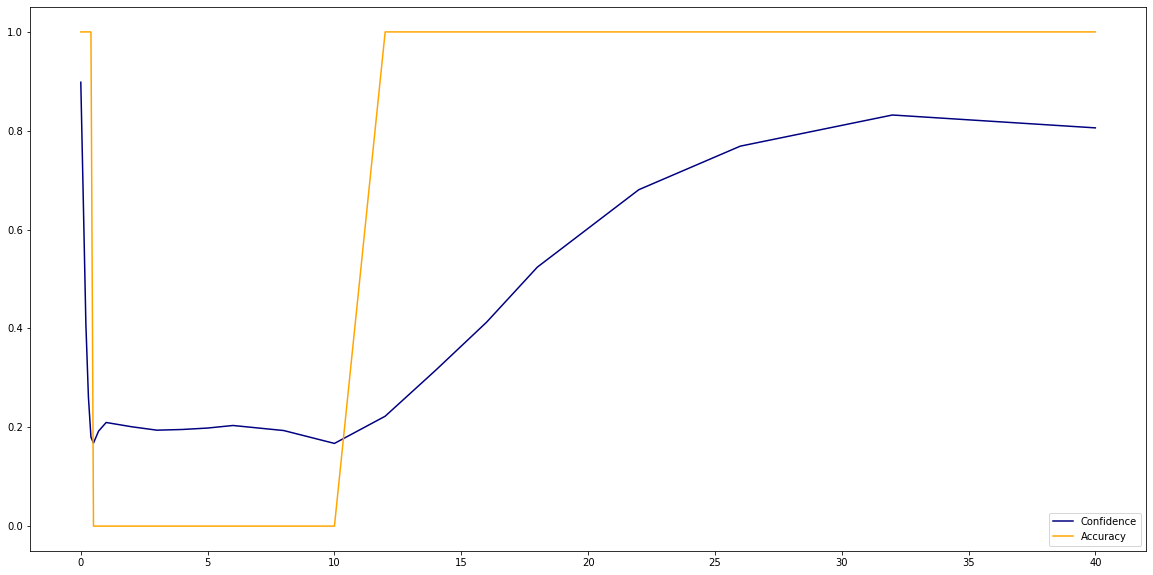

In [95]:
iterate_epsilons(432)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.89668226	meerkat, mierkat
0.1			1	0.8426662	meerkat, mierkat
0.2			1	0.7788054	meerkat, mierkat
0.3			1	0.69962835	meerkat, mierkat
0.4			1	0.6068959	meerkat, mierkat
0.5			1	0.5117072	meerkat, mierkat
0.7			1	0.3453938	meerkat, mierkat
1.0			1	0.1953709	meerkat, mierkat
2.0			0	0.07053705	mongoose
3.0			0	0.05462715	mongoose
4.0			0	0.06365303	leopard, Panthera pardus
5.0			0	0.072347924	leopard, Panthera pardus
6.0			0	0.07725474	leopard, Panthera pardus
8.0			0	0.08220487	leopard, Panthera pardus
10.0			0	0.07766279	leopard, Panthera pardus
12.0			0	0.073046066	leopard, Panthera pardus
14.0			0	0.065441765	leopard, Panthera pardus
16.0			0	0.064492784	Egyptian cat
18.0			0	0.07137908	Egyptian cat
22.0			0	0.066956304	Egyptian cat
26.0			0	0.06812441	brain coral
32.0			0	0.24822256	brain coral
40.0			0	0.29013708	sock


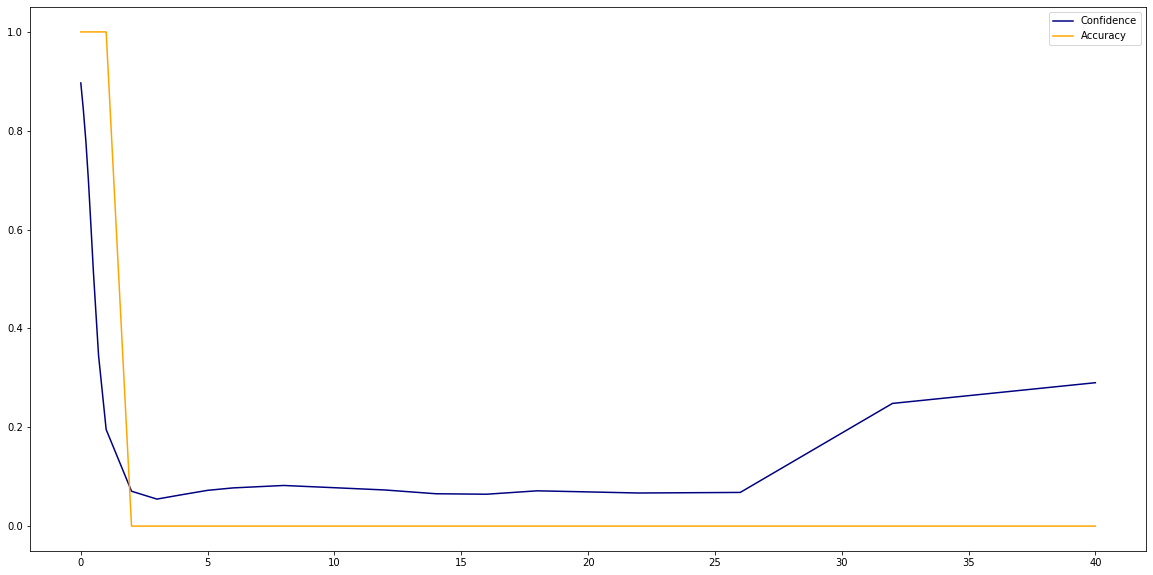

In [96]:
iterate_epsilons(28)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.956671	goose
0.1			1	0.85017174	goose
0.2			1	0.64265287	goose
0.3			1	0.41329703	goose
0.4			1	0.2503109	goose
0.5			1	0.15213712	goose
0.7			1	0.06123563	goose
1.0			1	0.023537397	goose
2.0			0	0.016210517	cowboy hat, ten-gallon hat
3.0			0	0.020918274	cowboy hat, ten-gallon hat
4.0			0	0.023618404	bustard
5.0			0	0.03441033	bustard
6.0			0	0.049985733	bustard
8.0			0	0.08660966	bustard
10.0			0	0.09751029	bustard
12.0			0	0.095931195	bustard
14.0			0	0.090154685	bustard
16.0			0	0.09006686	bustard
18.0			0	0.09471761	bustard
22.0			0	0.09840036	bustard
26.0			0	0.108786836	bustard
32.0			0	0.2403798	ruffed grouse, partridge, Bonasa umbellus
40.0			0	0.27309498	ruffed grouse, partridge, Bonasa umbellus


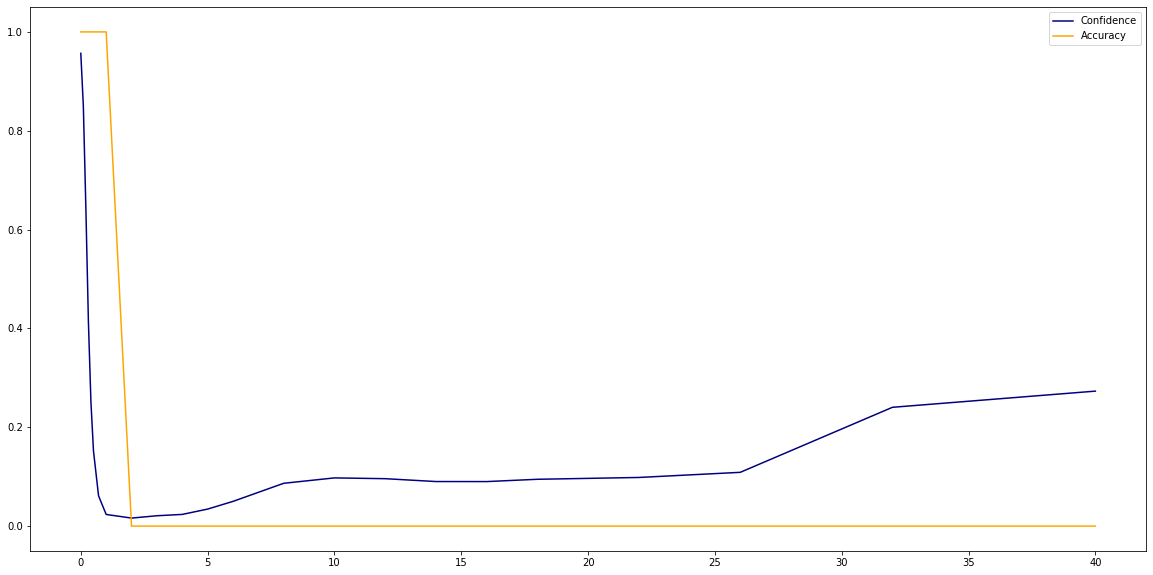

In [97]:
iterate_epsilons(29)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8916601	oystercatcher, oyster catcher
0.1			1	0.7187698	oystercatcher, oyster catcher
0.2			1	0.54159766	oystercatcher, oyster catcher
0.3			1	0.41286704	oystercatcher, oyster catcher
0.4			1	0.3320735	oystercatcher, oyster catcher
0.5			1	0.27710265	oystercatcher, oyster catcher
0.7			1	0.21350215	oystercatcher, oyster catcher
1.0			1	0.17391019	oystercatcher, oyster catcher
2.0			1	0.17523278	oystercatcher, oyster catcher
3.0			1	0.23270682	oystercatcher, oyster catcher
4.0			1	0.24771328	oystercatcher, oyster catcher
5.0			1	0.29038793	oystercatcher, oyster catcher
6.0			1	0.3768897	oystercatcher, oyster catcher
8.0			1	0.5554285	oystercatcher, oyster catcher
10.0			1	0.6141285	oystercatcher, oyster catcher
12.0			1	0.62475955	oystercatcher, oyster catcher
14.0			1	0.64022845	oystercatcher, oyster catcher
16.0			1	0.6605509	oystercatcher, oyster catcher
18.0			1	0.6375172	oystercatcher, oyster catcher
22.0			1	0.52399534	oystercatcher,

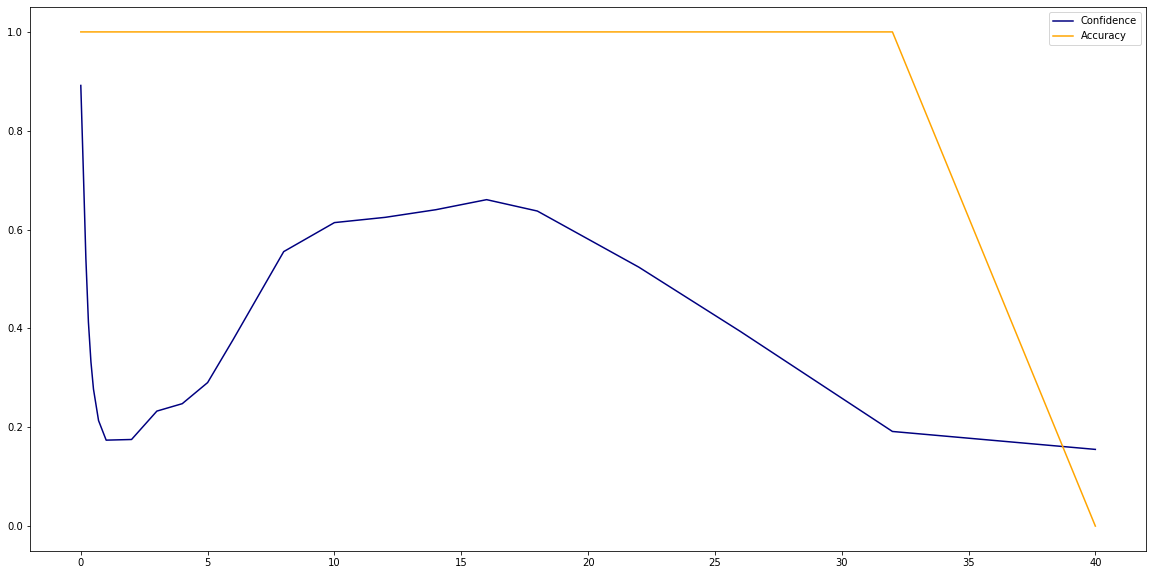

In [98]:
iterate_epsilons(323)

## Confidence 80%

In [78]:
result_aggregated = pd.read_csv("results/googleNet_ImageNet_clean_aggregated.csv", index_col=0)

#result_aggregated.sort_values(by=["Confidence Mean"], ascending=False, inplace=False)

## Filter for medium confidence
result_aggregated.loc[result_aggregated["Confidence Mean"] <= 0.8]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
116,324,0.799693,0.000000,1,cabbage butterfly
117,483,0.793980,0.120596,5,castle
118,264,0.793519,0.000000,1,"Cardigan, Cardigan Welsh corgi"
119,580,0.789357,0.166885,4,"greenhouse, nursery, glasshouse"
120,741,0.787660,0.186281,3,"prayer rug, prayer mat"
...,...,...,...,...,...
447,907,0.058586,0.000000,1,wine bottle
448,241,0.055452,0.000000,1,EntleBucher
449,431,0.049087,0.000000,1,bassinet
450,212,0.043343,0.000000,1,English setter


In [80]:
get_image_by_class_index(324)
get_image_by_class_index(483)
get_image_by_class_index(264)
get_image_by_class_index(580)
get_image_by_class_index(741)

49
528
895
375
17


Epsilon 	 Accuracy 	 Confidence 	 Label
0			0	0.2919759	daisy
0.1			0	0.31092423	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
0.2			0	0.32905653	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
0.3			0	0.32155105	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
0.4			0	0.29341653	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
0.5			0	0.26447892	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
0.7			0	0.21036068	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
1.0			0	0.13562807	yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum
2.0			0	0.13685444	vine snake
3.0			0	0.17509171	vine snake
4.0			0	0.18778475	vine snake
5.0			0	0.17749648	vine snake
6.0			0	0.1750254	vine snake
8.0			0	0.15861626	

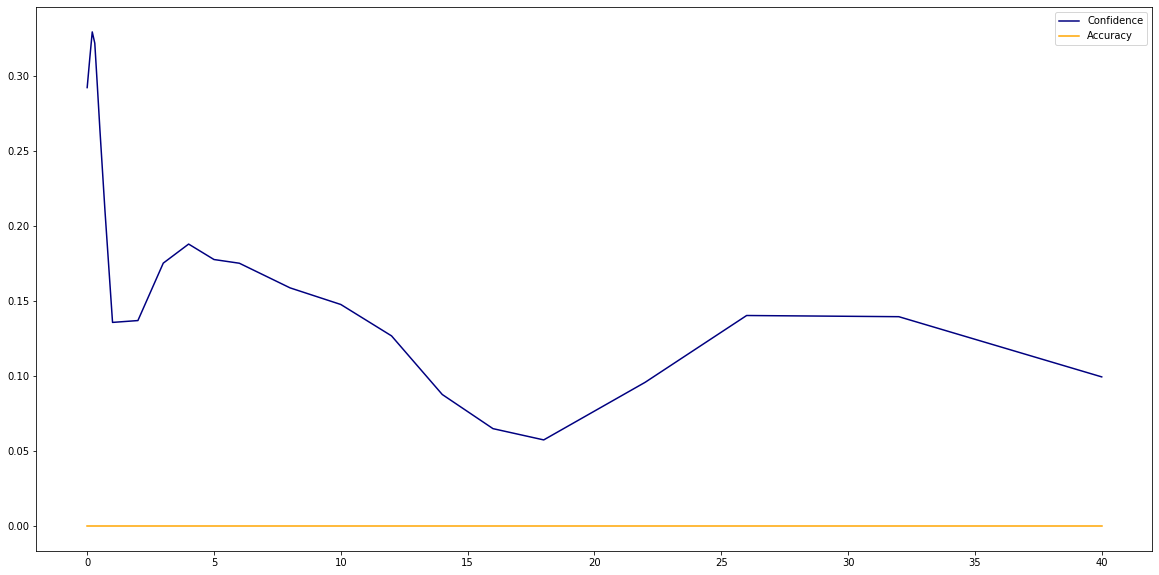

In [81]:
iterate_epsilons(49)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8741497	castle
0.1			1	0.5764716	castle
0.2			1	0.28794137	castle
0.3			1	0.14415875	castle
0.4			0	0.13095121	triumphal arch
0.5			0	0.1375503	triumphal arch
0.7			0	0.14543954	triumphal arch
1.0			0	0.14800537	triumphal arch
2.0			0	0.14686343	triumphal arch
3.0			0	0.14582294	triumphal arch
4.0			0	0.14714171	triumphal arch
5.0			0	0.14536409	triumphal arch
6.0			0	0.14021143	triumphal arch
8.0			0	0.121330805	obelisk
10.0			0	0.12665606	obelisk
12.0			0	0.10822989	obelisk
14.0			0	0.10070149	obelisk
16.0			0	0.107911386	monastery
18.0			0	0.1170596	monastery
20.0			0	0.12936172	monastery


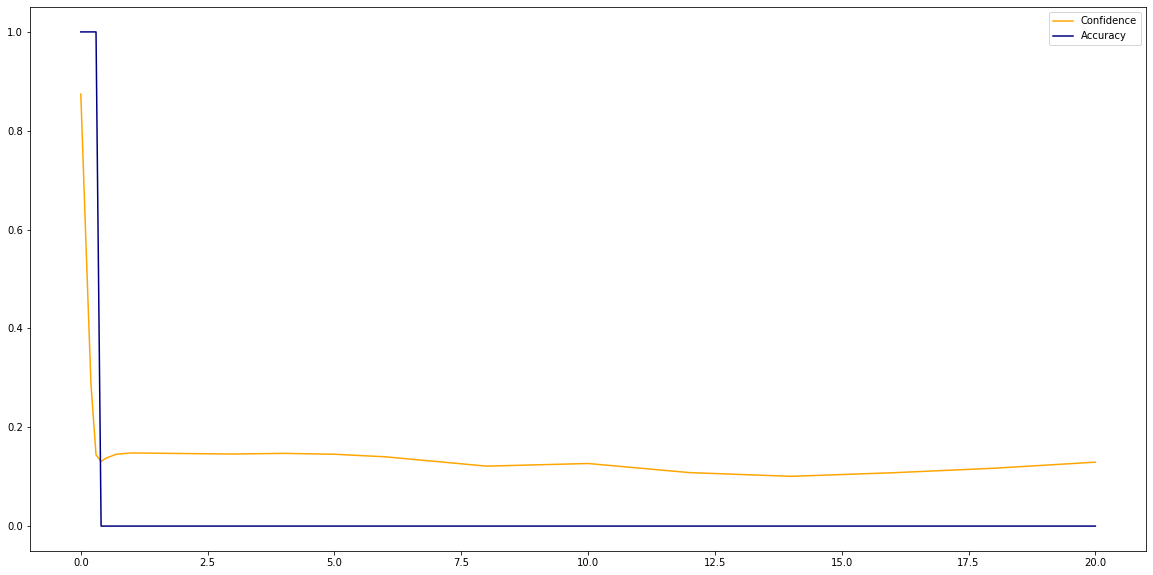

In [14]:
iterate_epsilons(528)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.7935192	Cardigan, Cardigan Welsh corgi
0.1			1	0.56296283	Cardigan, Cardigan Welsh corgi
0.2			1	0.35109964	Cardigan, Cardigan Welsh corgi
0.3			1	0.20444839	Cardigan, Cardigan Welsh corgi
0.4			0	0.16080888	Border collie
0.5			0	0.13753837	Border collie
0.7			0	0.09631245	Border collie
1.0			0	0.06078097	Border collie
2.0			0	0.038016062	kelpie
3.0			0	0.041097485	Saluki, gazelle hound
4.0			0	0.047470514	Saluki, gazelle hound
5.0			0	0.04424802	Saluki, gazelle hound
6.0			0	0.044431698	kelpie
8.0			0	0.0569641	kelpie
10.0			0	0.058663044	kelpie
12.0			0	0.056850027	kelpie
14.0			0	0.05875997	kelpie
16.0			0	0.059917677	kelpie
18.0			0	0.06563768	kelpie
22.0			0	0.1145094	kelpie
26.0			0	0.18542041	kelpie
32.0			0	0.1883452	kelpie
40.0			0	0.24334022	standard poodle


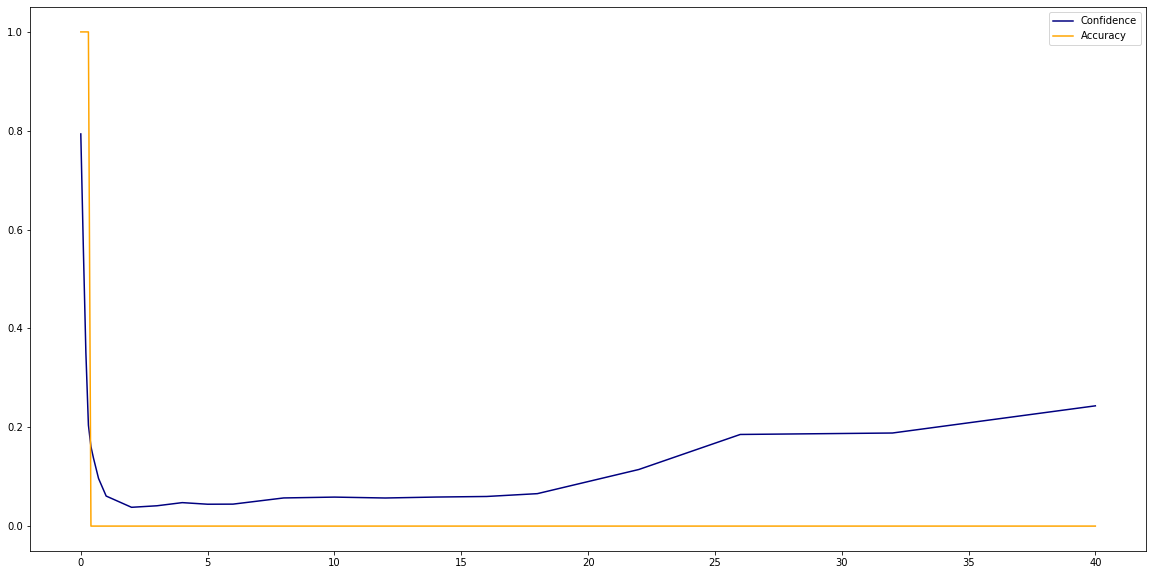

In [83]:
iterate_epsilons(895)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.909115	greenhouse, nursery, glasshouse
0.1			1	0.70151293	greenhouse, nursery, glasshouse
0.2			1	0.4098829	greenhouse, nursery, glasshouse
0.3			0	0.21292256	sea urchin
0.4			0	0.26067215	sea urchin
0.5			0	0.28422317	sea urchin
0.7			0	0.283889	sea urchin
1.0			0	0.24556866	lionfish
2.0			0	0.41794074	lionfish
3.0			0	0.38989797	lionfish
4.0			0	0.32185906	lionfish
5.0			0	0.25038543	lionfish
6.0			0	0.2021108	lionfish
8.0			0	0.11888806	lionfish
10.0			0	0.12044038	brain coral
12.0			0	0.16352703	brain coral
14.0			0	0.23877715	brain coral
16.0			0	0.2909673	brain coral
18.0			0	0.3081127	brain coral
22.0			0	0.34260792	brain coral
26.0			0	0.3951471	brain coral
32.0			0	0.38036397	brain coral
40.0			0	0.40183866	brain coral


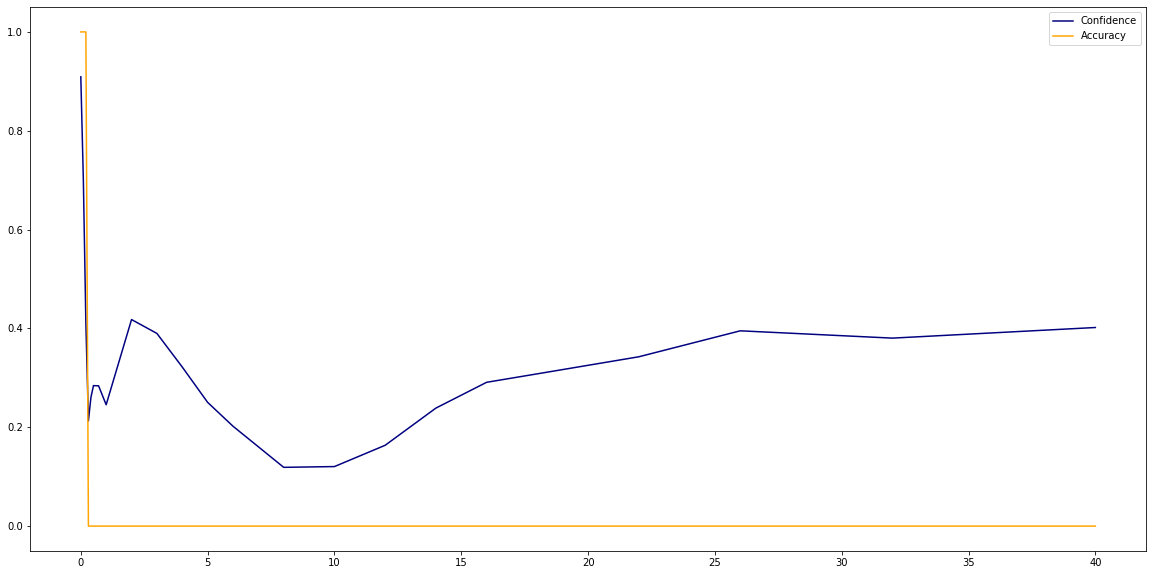

In [84]:
iterate_epsilons(375)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.90352654	prayer rug, prayer mat
0.1			1	0.8318421	prayer rug, prayer mat
0.2			1	0.74003893	prayer rug, prayer mat
0.3			1	0.63291466	prayer rug, prayer mat
0.4			1	0.518757	prayer rug, prayer mat
0.5			1	0.41481838	prayer rug, prayer mat
0.7			0	0.31115878	vestment
1.0			0	0.36526692	vestment
2.0			0	0.41038358	vestment
3.0			0	0.41952774	vestment
4.0			0	0.42785954	vestment
5.0			0	0.4236567	vestment
6.0			0	0.42169693	vestment
8.0			0	0.43939975	vestment
10.0			0	0.43537396	vestment
12.0			0	0.4376597	vestment
14.0			0	0.45328262	vestment
16.0			0	0.4749162	vestment
18.0			0	0.48175445	vestment
22.0			0	0.41501677	vestment
26.0			0	0.36127254	vestment
32.0			0	0.23490661	vestment
40.0			1	0.2436593	prayer rug, prayer mat


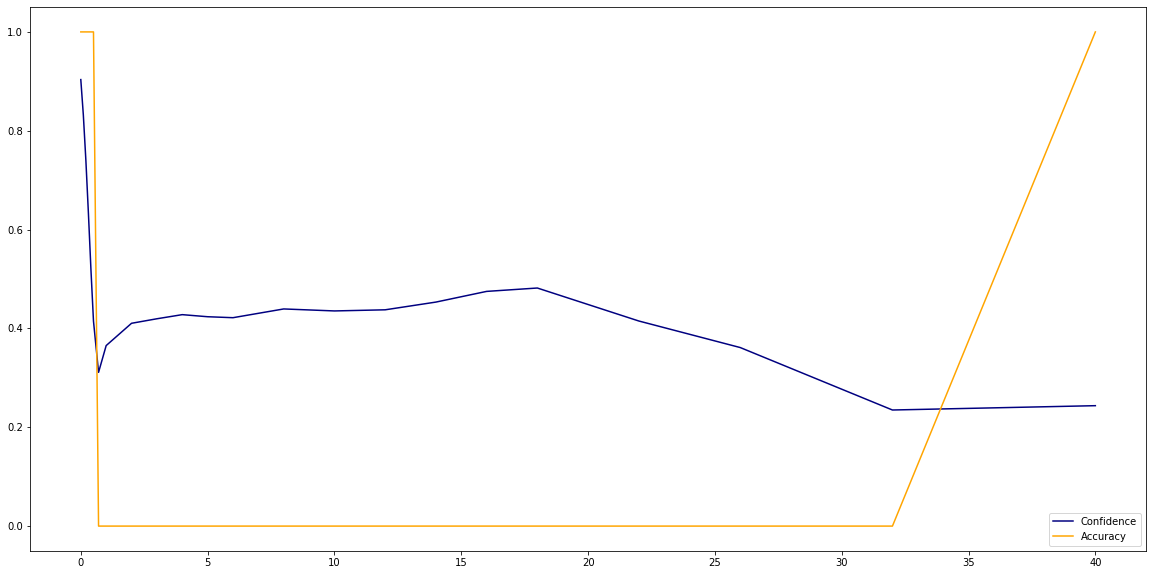

In [85]:
iterate_epsilons(17)

## Confidence 70%

In [99]:
result_aggregated.loc[result_aggregated["Confidence Mean"] <= 0.7]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
178,511,0.699373,0.151368,5,convertible
179,975,0.697038,0.161803,3,"lakeside, lakeshore"
180,646,0.695137,0.193753,4,"maze, labyrinth"
181,302,0.692550,0.000000,1,"ground beetle, carabid beetle"
182,57,0.687411,0.252985,3,"garter snake, grass snake"
...,...,...,...,...,...
447,907,0.058586,0.000000,1,wine bottle
448,241,0.055452,0.000000,1,EntleBucher
449,431,0.049087,0.000000,1,bassinet
450,212,0.043343,0.000000,1,English setter


In [100]:
get_image_by_class_index(511)
get_image_by_class_index(975)
get_image_by_class_index(646)
get_image_by_class_index(302)
get_image_by_class_index(57)

244
554
145
54
287


Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.7493753	convertible
0.1			1	0.618022	convertible
0.2			1	0.4882116	convertible
0.3			1	0.37750453	convertible
0.4			1	0.29232243	convertible
0.5			1	0.22993268	convertible
0.7			1	0.15183416	convertible
1.0			1	0.09664092	convertible
2.0			0	0.0694018	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
3.0			0	0.07338239	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
4.0			0	0.07569926	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
5.0			0	0.08037085	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
6.0			0	0.08652796	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
8.0			0	0.111968905	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
10.0			0	0.14512485	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, wag

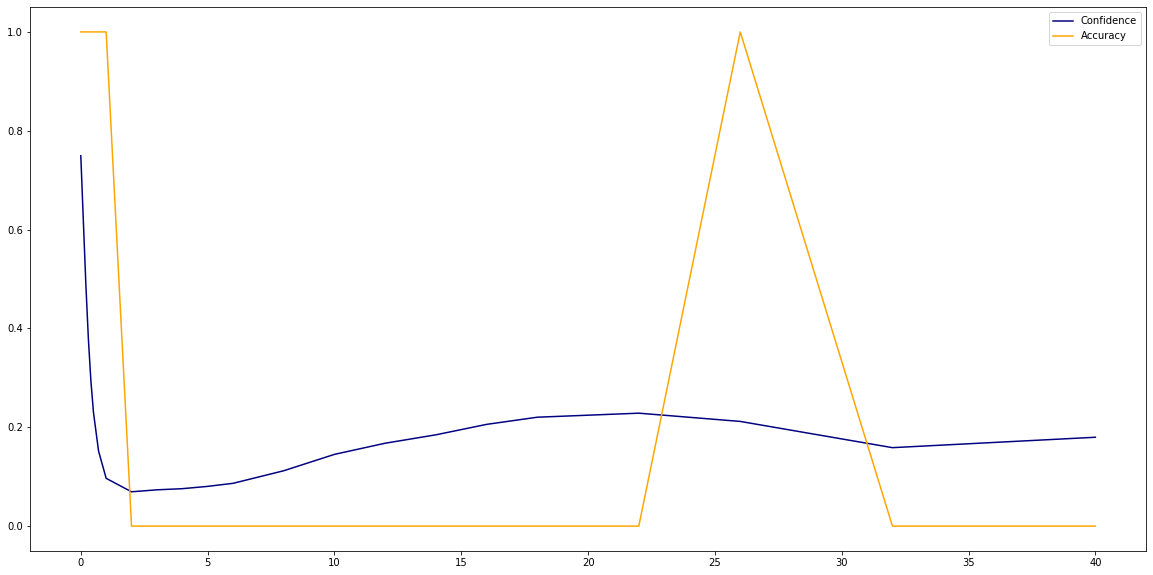

In [101]:
iterate_epsilons(244)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.5011719	lakeside, lakeshore
0.1			1	0.30786353	lakeside, lakeshore
0.2			1	0.20171125	lakeside, lakeshore
0.3			1	0.13889748	lakeside, lakeshore
0.4			1	0.10203683	lakeside, lakeshore
0.5			1	0.079560265	lakeside, lakeshore
0.7			1	0.05325291	lakeside, lakeshore
1.0			0	0.042203225	hare
2.0			0	0.1777881	hare
3.0			0	0.1889291	hare
4.0			0	0.17403926	hare
5.0			0	0.1856514	hare
6.0			0	0.18371856	hare
8.0			0	0.141802	hare
10.0			0	0.114389814	hare
12.0			0	0.09982204	hare
14.0			0	0.09900966	hare
16.0			0	0.09636823	hare
18.0			0	0.09947232	hare
22.0			0	0.07536713	ibex, Capra ibex
26.0			0	0.11942735	ibex, Capra ibex
32.0			0	0.10181058	ibex, Capra ibex
40.0			0	0.04265332	jigsaw puzzle


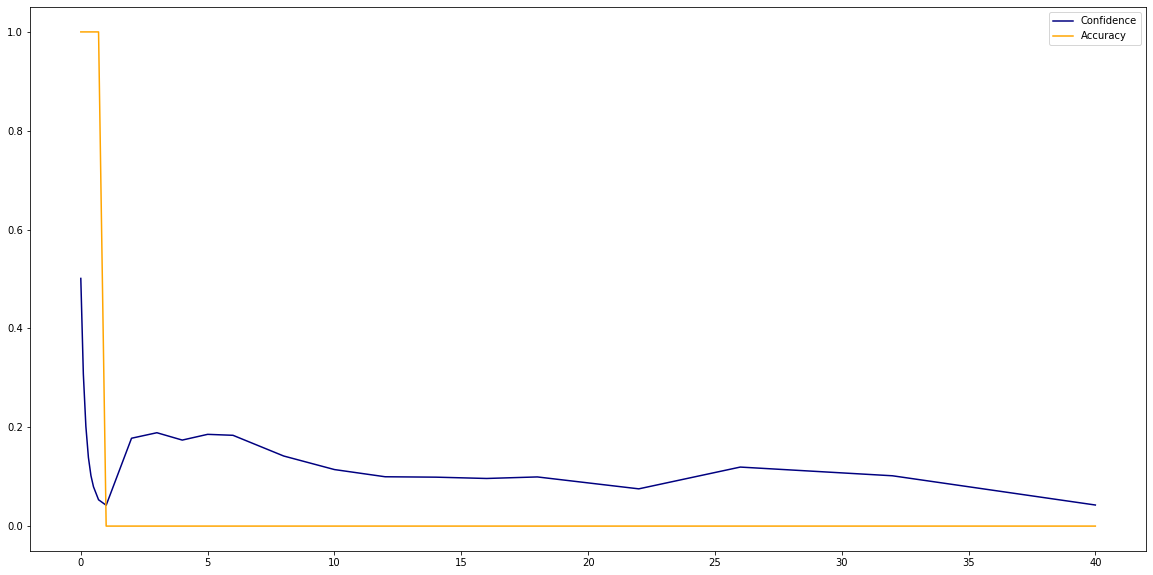

In [102]:
iterate_epsilons(554)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.6607222	maze, labyrinth
0.1			1	0.34487048	maze, labyrinth
0.2			1	0.1783895	maze, labyrinth
0.3			1	0.10929928	maze, labyrinth
0.4			0	0.09830297	hay
0.5			0	0.08910452	hay
0.7			0	0.07102427	hay
1.0			0	0.05319959	hay
2.0			0	0.06266158	thatch, thatched roof
3.0			0	0.07739785	thatch, thatched roof
4.0			0	0.09802153	thatch, thatched roof
5.0			0	0.10866357	thatch, thatched roof
6.0			0	0.122594886	thatch, thatched roof
8.0			0	0.12903315	thatch, thatched roof
10.0			0	0.13172007	greenhouse, nursery, glasshouse
12.0			0	0.17140783	greenhouse, nursery, glasshouse
14.0			0	0.2168363	greenhouse, nursery, glasshouse
16.0			0	0.26307946	greenhouse, nursery, glasshouse
18.0			0	0.29427156	greenhouse, nursery, glasshouse
22.0			0	0.30280173	greenhouse, nursery, glasshouse
26.0			0	0.26660272	greenhouse, nursery, glasshouse
32.0			0	0.1813556	greenhouse, nursery, glasshouse
40.0			0	0.18927671	chainlink fence


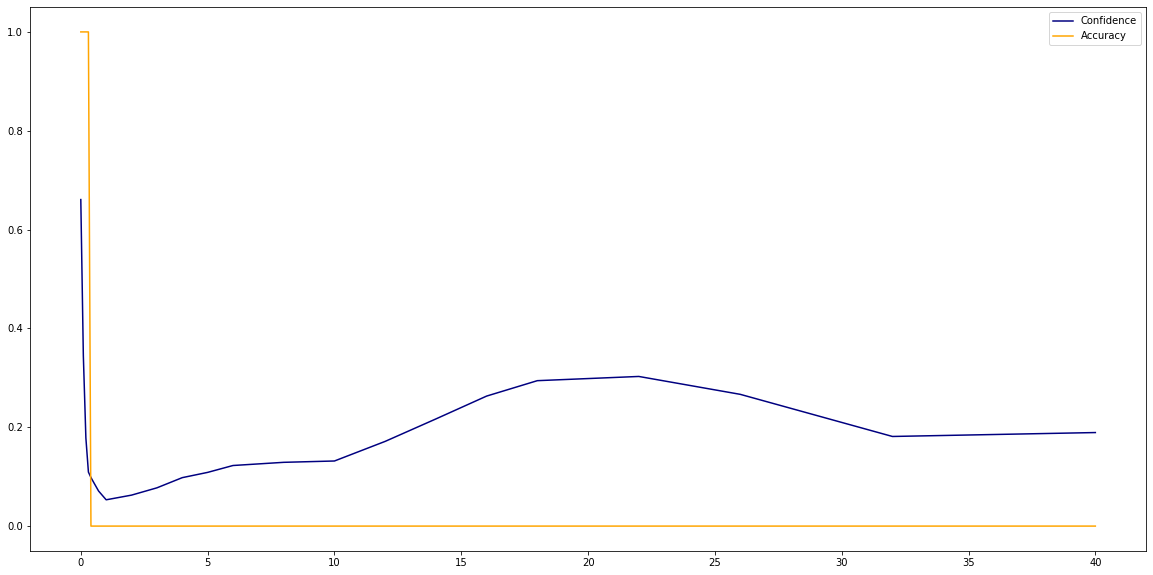

In [103]:
iterate_epsilons(145)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.6925501	ground beetle, carabid beetle
0.1			1	0.41281715	ground beetle, carabid beetle
0.2			1	0.1706435	ground beetle, carabid beetle
0.3			1	0.058921017	ground beetle, carabid beetle
0.4			0	0.067500986	cleaver, meat cleaver, chopper
0.5			0	0.09942185	cleaver, meat cleaver, chopper
0.7			0	0.13181943	cleaver, meat cleaver, chopper
1.0			0	0.14410794	cleaver, meat cleaver, chopper
2.0			0	0.12605332	cauliflower
3.0			0	0.17482844	cauliflower
4.0			0	0.18846112	cauliflower
5.0			0	0.16797279	cauliflower
6.0			0	0.12336258	cauliflower
8.0			0	0.08650259	cauliflower
10.0			0	0.06548866	cauliflower
12.0			0	0.05887155	cauliflower
14.0			0	0.087549746	cleaver, meat cleaver, chopper
16.0			0	0.105238356	cleaver, meat cleaver, chopper
18.0			0	0.13489167	sea cucumber, holothurian
22.0			0	0.29997313	sea cucumber, holothurian
26.0			0	0.37400496	sea cucumber, holothurian
32.0			0	0.520683	sea cucumber, holothurian
40.0			0	0.46863732	sea cucumb

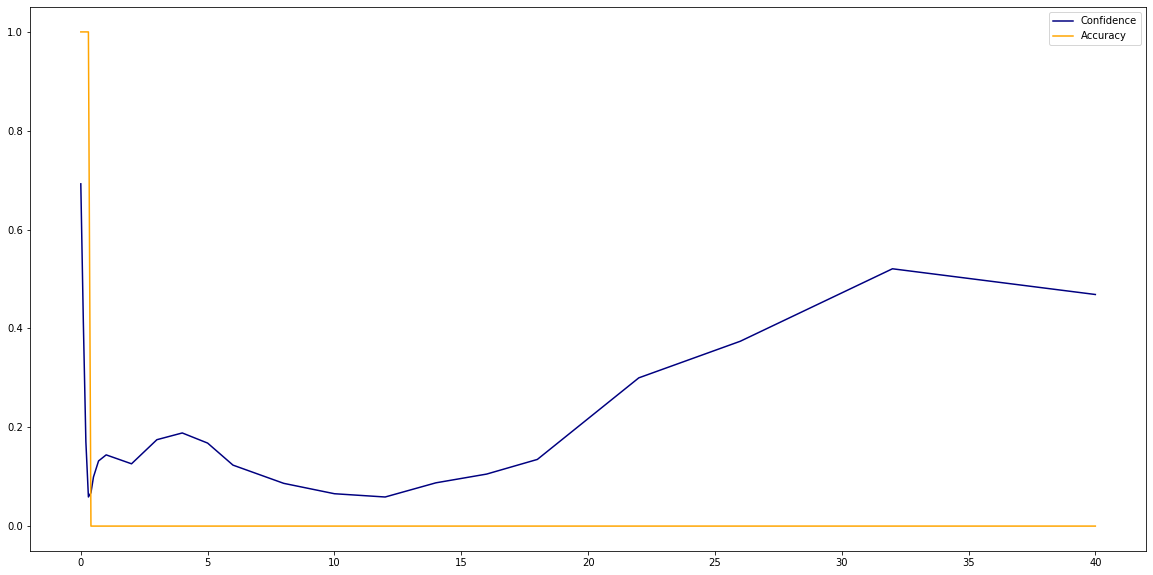

In [104]:
iterate_epsilons(54)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8378881	garter snake, grass snake
0.1			1	0.6794855	garter snake, grass snake
0.2			1	0.4807427	garter snake, grass snake
0.3			1	0.30139133	garter snake, grass snake
0.4			1	0.17810357	garter snake, grass snake
0.5			0	0.19178002	common newt, Triturus vulgaris
0.7			0	0.23483567	common newt, Triturus vulgaris
1.0			0	0.27351582	common newt, Triturus vulgaris
2.0			0	0.32726339	common newt, Triturus vulgaris
3.0			0	0.31627014	common newt, Triturus vulgaris
4.0			0	0.2876238	common newt, Triturus vulgaris
5.0			0	0.25377378	common newt, Triturus vulgaris
6.0			0	0.22401682	common newt, Triturus vulgaris
8.0			0	0.22243874	common newt, Triturus vulgaris
10.0			0	0.17386995	common newt, Triturus vulgaris
12.0			0	0.17340803	common newt, Triturus vulgaris
14.0			0	0.18147387	common newt, Triturus vulgaris
16.0			0	0.16331252	common newt, Triturus vulgaris
18.0			0	0.13208398	common newt, Triturus vulgaris
22.0			0	0.08828649	crayfish, crawfi

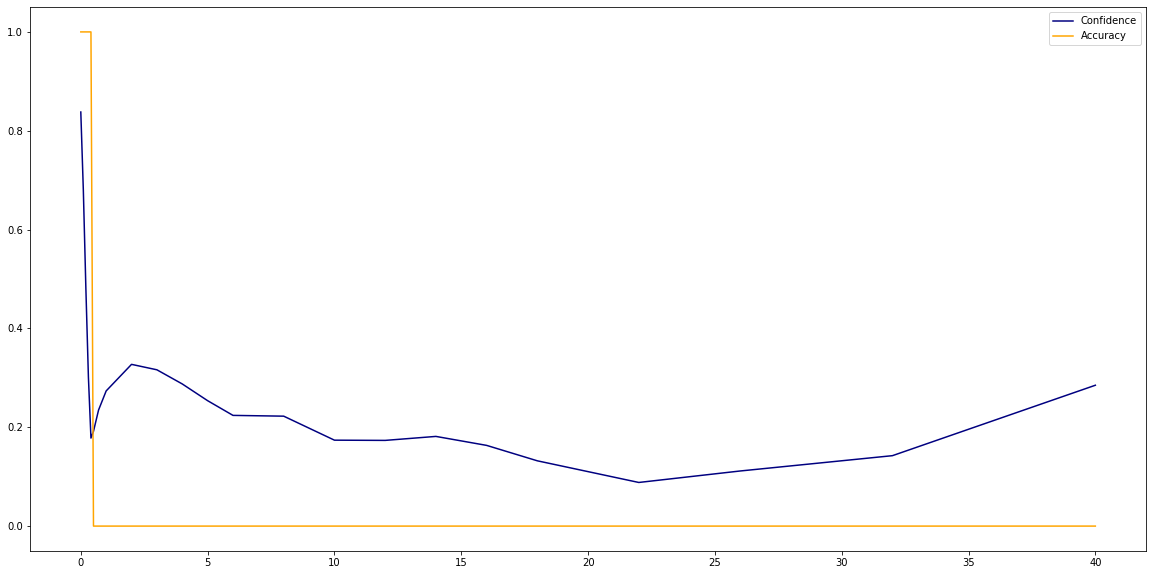

In [105]:
iterate_epsilons(287)

## Confidence 60%

In [106]:
result_aggregated.loc[result_aggregated["Confidence Mean"] <= 0.6]

,Class Index,Confidence Mean,Confidence Std,Frequency,Class Name
244,692,0.599850,0.235084,3,packet
245,886,0.599196,0.334437,2,vending machine
246,708,0.599132,0.245678,3,"pedestal, plinth, footstall"
247,807,0.599009,0.000000,1,"solar dish, solar collector, solar furnace"
248,351,0.597540,0.000000,1,hartebeest
...,...,...,...,...,...
447,907,0.058586,0.000000,1,wine bottle
448,241,0.055452,0.000000,1,EntleBucher
449,431,0.049087,0.000000,1,bassinet
450,212,0.043343,0.000000,1,English setter


In [108]:
get_image_by_class_index(692)
get_image_by_class_index(886)
get_image_by_class_index(708)
get_image_by_class_index(807)
get_image_by_class_index(351)

39
999
101
100
217


Epsilon 	 Accuracy 	 Confidence 	 Label
0			0	0.12903363	binder, ring-binder
0.1			0	0.10222825	wardrobe, closet, press
0.2			0	0.12198008	wardrobe, closet, press
0.3			0	0.12936606	wardrobe, closet, press
0.4			0	0.12561354	wardrobe, closet, press
0.5			0	0.12142476	wardrobe, closet, press
0.7			0	0.1130162	wardrobe, closet, press
1.0			0	0.115896456	refrigerator, icebox
2.0			0	0.11570818	refrigerator, icebox
3.0			0	0.098102	medicine chest, medicine cabinet
4.0			0	0.09460828	wardrobe, closet, press
5.0			0	0.103412196	wardrobe, closet, press
6.0			0	0.122206	wardrobe, closet, press
8.0			0	0.19086275	wardrobe, closet, press
10.0			0	0.22287163	wardrobe, closet, press
12.0			0	0.2396525	wardrobe, closet, press
14.0			0	0.27302647	wardrobe, closet, press
16.0			0	0.31045693	wardrobe, closet, press
18.0			0	0.3205847	wardrobe, closet, press
22.0			0	0.35005853	wardrobe, closet, press
26.0			0	0.41613644	wardrobe, closet, press
32.0			0	0.3816663	wardrobe, closet, press
40.0			0	0.1769

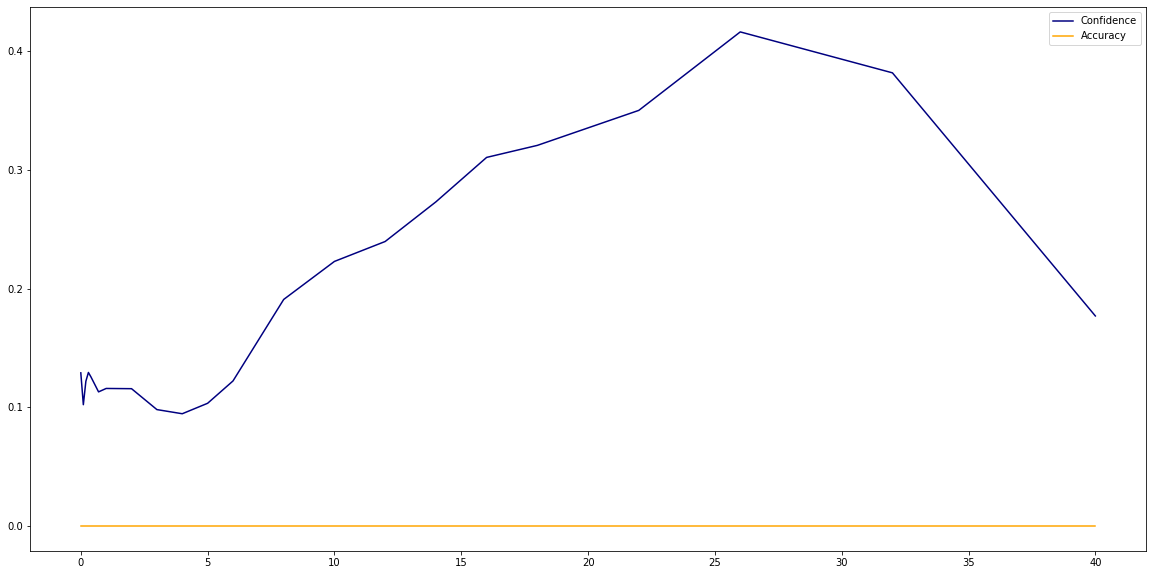

In [107]:
iterate_epsilons(39)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.93363255	vending machine
0.1			1	0.8641302	vending machine
0.2			1	0.7658041	vending machine
0.3			1	0.6467865	vending machine
0.4			1	0.5261379	vending machine
0.5			1	0.41807386	vending machine
0.7			1	0.2626304	vending machine
1.0			1	0.13626619	vending machine
2.0			0	0.046572108	grocery store, grocery, food market, market
3.0			0	0.03701749	grocery store, grocery, food market, market
4.0			0	0.035700724	grocery store, grocery, food market, market
5.0			0	0.034715325	grocery store, grocery, food market, market
6.0			0	0.036206517	grocery store, grocery, food market, market
8.0			0	0.0319893	grocery store, grocery, food market, market
10.0			0	0.029296683	grocery store, grocery, food market, market
12.0			0	0.02875747	library
14.0			0	0.029840063	confectionery, confectionary, candy store
16.0			0	0.028007086	confectionery, confectionary, candy store
18.0			0	0.035683177	throne
22.0			0	0.055240713	throne
26.0			0	0.0964005	prayer rug, 

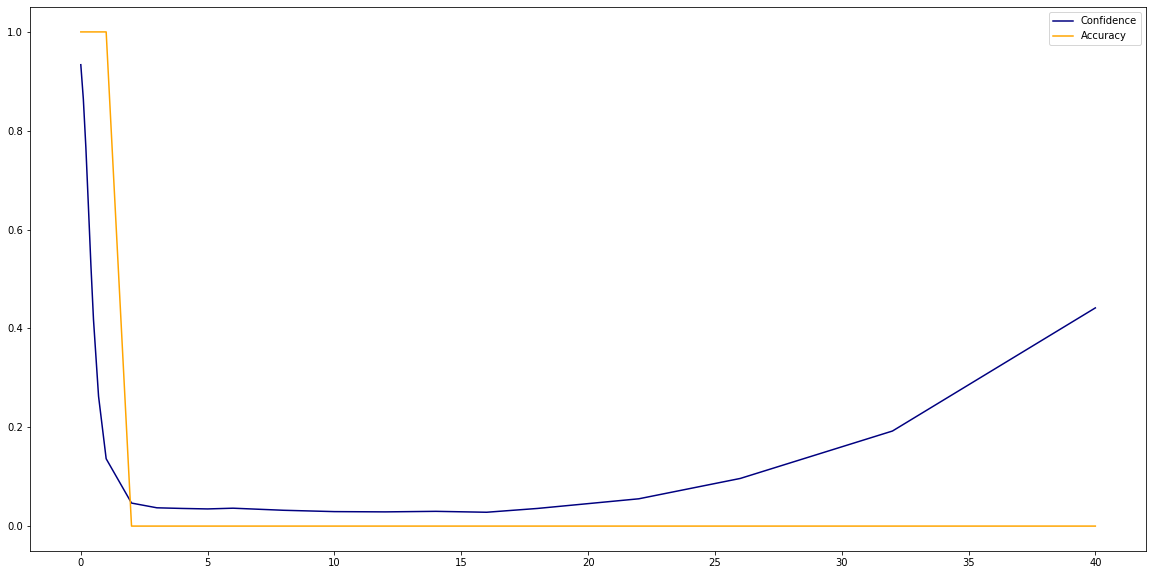

In [109]:
iterate_epsilons(999)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.34593737	pedestal, plinth, footstall
0.1			1	0.1234486	pedestal, plinth, footstall
0.2			0	0.098609	gown
0.3			0	0.113032445	gown
0.4			0	0.1180652	gown
0.5			0	0.12067513	gown
0.7			0	0.12016829	gown
1.0			0	0.13438144	overskirt
2.0			0	0.14365745	overskirt
3.0			0	0.14531241	overskirt
4.0			0	0.13384315	overskirt
5.0			0	0.11806887	overskirt
6.0			0	0.114069216	overskirt
8.0			0	0.11248621	overskirt
10.0			0	0.11453268	overskirt
12.0			0	0.11468543	overskirt
14.0			0	0.11461181	overskirt
16.0			0	0.121266246	overskirt
18.0			0	0.14429413	overskirt
22.0			0	0.17127112	hoopskirt, crinoline
26.0			0	0.18400535	overskirt
32.0			0	0.15794314	overskirt
40.0			0	0.088406004	overskirt


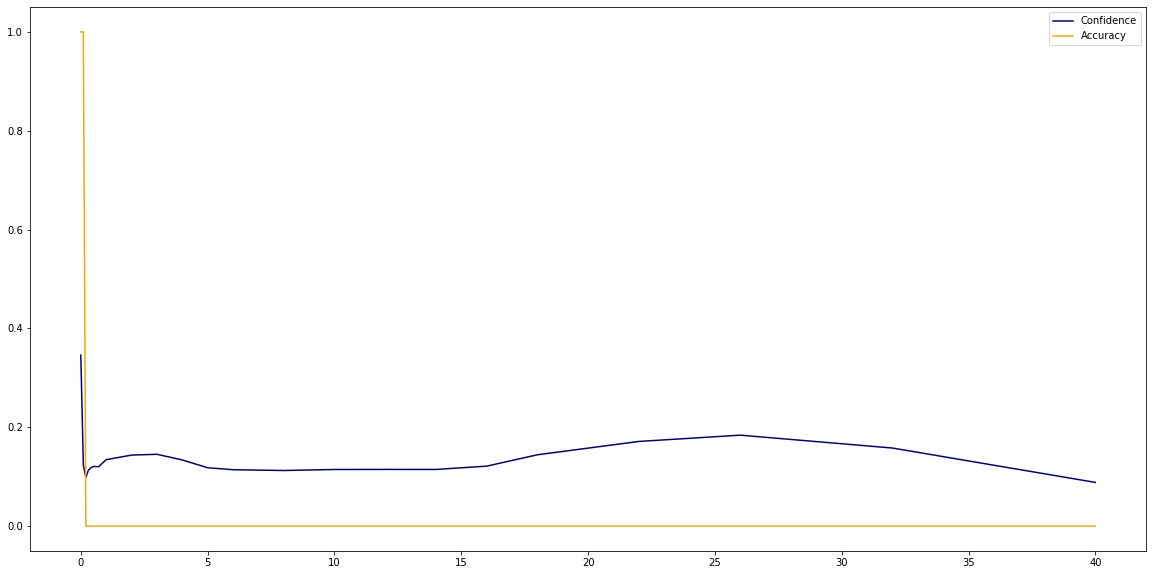

In [110]:
iterate_epsilons(101)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.5990088	solar dish, solar collector, solar furnace
0.1			1	0.12678362	solar dish, solar collector, solar furnace
0.2			0	0.14128397	boathouse
0.3			0	0.1465338	boathouse
0.4			0	0.14540115	boathouse
0.5			0	0.14426525	boathouse
0.7			0	0.13790965	boathouse
1.0			0	0.14235765	dam, dike, dyke
2.0			0	0.17393656	patio, terrace
3.0			0	0.20674524	patio, terrace
4.0			0	0.19536343	patio, terrace
5.0			0	0.19341592	patio, terrace
6.0			0	0.15609352	patio, terrace
8.0			0	0.087031566	patio, terrace
10.0			0	0.099483125	throne
12.0			0	0.14205813	throne
14.0			0	0.16982087	throne
16.0			0	0.18424757	throne
18.0			0	0.19477886	throne
22.0			0	0.18724969	throne
26.0			0	0.1385201	throne
32.0			0	0.25731122	prayer rug, prayer mat
40.0			0	0.5132733	prayer rug, prayer mat


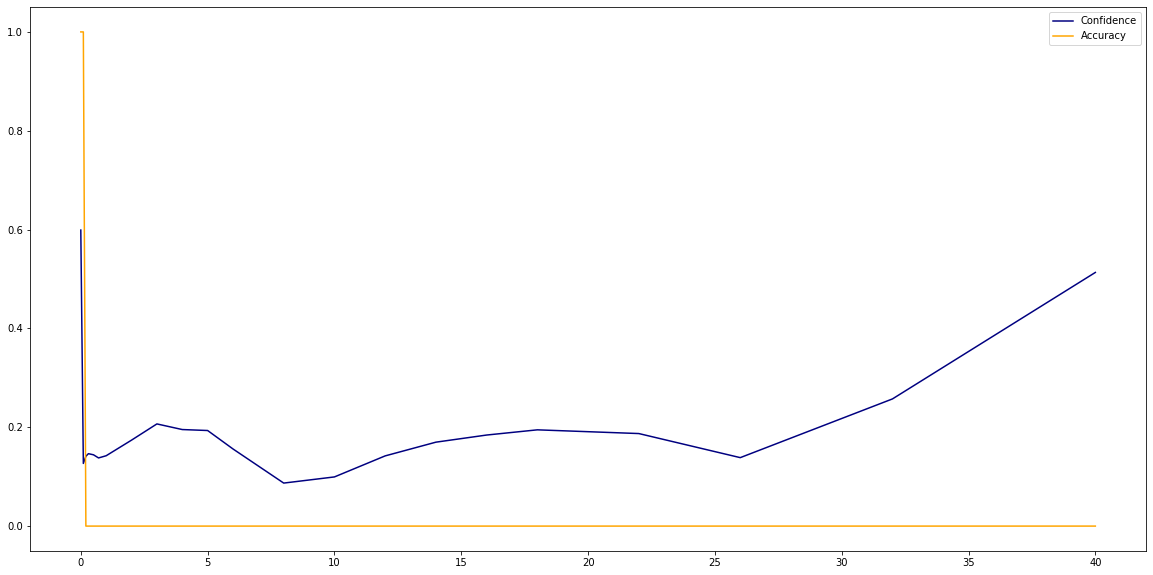

In [111]:
iterate_epsilons(100)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.59753966	hartebeest
0.1			1	0.39037278	hartebeest
0.2			1	0.24247335	hartebeest
0.3			0	0.16087025	gazelle
0.4			0	0.13689953	gazelle
0.5			0	0.11693528	gazelle
0.7			0	0.08975963	sorrel
1.0			0	0.07733309	sorrel
2.0			0	0.06526812	sorrel
3.0			0	0.067382514	ram, tup
4.0			0	0.08061369	ram, tup
5.0			0	0.09483424	ram, tup
6.0			0	0.11011869	ram, tup
8.0			0	0.17040427	ram, tup
10.0			0	0.22762582	ram, tup
12.0			0	0.29031843	ram, tup
14.0			0	0.35407677	ram, tup
16.0			0	0.40624228	ram, tup
18.0			0	0.4565621	ram, tup
22.0			0	0.5238282	ram, tup
26.0			0	0.53033155	ram, tup
32.0			0	0.47023708	ram, tup
40.0			0	0.34942368	ram, tup


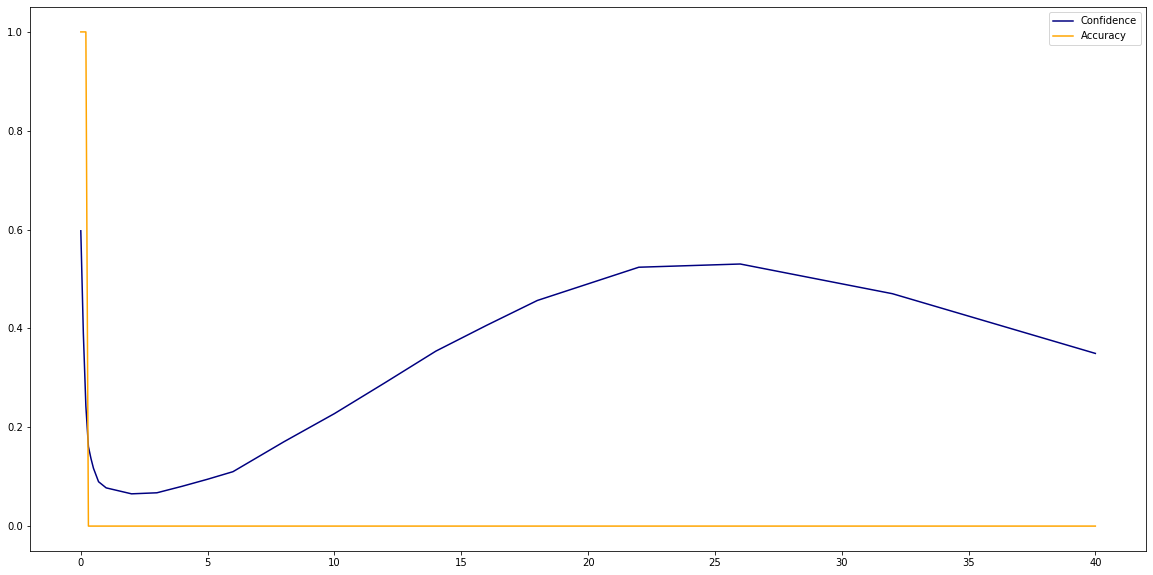

In [112]:
iterate_epsilons(217)

In [ ]:
## Random example for larger epsilon
epsilon = 12/255
idx = 440

compare_examples_fgsm(epsilon, idx)

## Isolated attack illustration

Some results here ...

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

In [56]:
# Set perturbation
epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255,
            4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]

accurcy_top1 = []
accurcy_top5 = []
confidence_adversarial = []


for epsilon in epsilons:   
    acc_sub_adver_top1 = []
    acc_sub_adver_top5 = []
    conf_sub_adver = []    
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon*255))
        print("Sample: "+ str(i))
        print("Accuracy adversarial: {:.2f}".format(np.mean(acc_sub_adver_top1)))
        print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))
        
        # Predict with clean image
        gradient, corr, _, _, _ = predict(model, image_as_tensor, label, return_grad=True)

        # Generate adversarial example only if initial prediction was correct
        if corr == 1:            
            # Predict with adversarial image
            perturbed_data = apply_fgsm(image_as_tensor, epsilon, gradient)
            _, top1, top5, conf, _ = predict(model, perturbed_data, label)
            acc_sub_adver_top1.append(top1)
            acc_sub_adver_top5.append(top5)
            conf_sub_adver.append(conf)
            
        else:
            acc_sub_adver_top1.append(0)
            acc_sub_adver_top5.append(0)
            conf_sub_adver.append(0)
    
        i += 1
        
    # Add accuracies and confidences for clean and adversarial example
    accurcy_top1.append(np.mean(acc_sub_adver_top1))
    accurcy_top5.append(np.mean(acc_sub_adver_top5))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
epsilon = np.array(epsilons) * 255
result["Epsilon_255"] = epsilon
result["Accuracy Top 1"] = accurcy_top1
result["Accuracy Top 5"] = accurcy_top5
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_FGSM.csv")

Running for epsilon 60.00
Sample: 1000
Accuracy adversarial: 0.02
Confidence adversarial: 0.25


## 3. Discussion

In [12]:
# Load results
result = pd.read_csv("results/googleNet_ImageNet_FGSM.csv")
accurcy_top1 = result["Accuracy Top 1"]
accurcy_top5 = result["Accuracy Top 5"]
confidence_adversarial = result["Confidence"]
epsilon = result["Epsilon_255"]

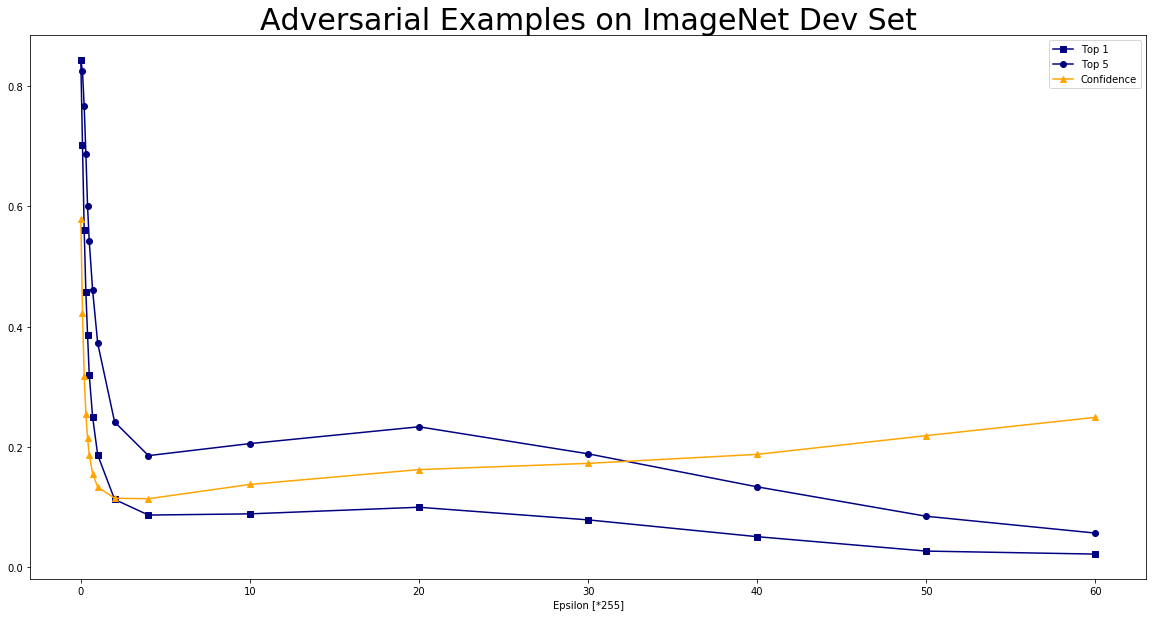

<Figure size 1440x720 with 0 Axes>

In [13]:
plt.plot(epsilon, accurcy_top1, "s-", color="navy", label="Top 1")
plt.plot(epsilon, accurcy_top5, "o-", color="navy", label="Top 5")
plt.plot(epsilon, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on ImageNet Dev Set", fontsize=30)
plt.legend()
plt.show()

plt.savefig("./plots/FGSM/Adversarial_Examples-FGSM.pdf")
plt.savefig("./plots/FGSM/png/Adversarial_Examples-FGSM.png")

Some text ...

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*